# 1. Imports

In [1]:
# check 
!ipython kernelspec list



Available kernels:
  python3    C:\Users\HP\Anaconda3\envs\Ball4WSD\share\jupyter\kernels\python3


[TerminalIPythonApp] WARNING | Subcommand `ipython kernelspec` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter kernelspec` in the future
[ListKernelSpecs] WARNING | Config option `kernel_spec_manager_class` not recognized by `ListKernelSpecs`.


In [2]:
import types

def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

excludes = ['builtins', 'types', 'sys']

imported_modules = [module for module in imports() if module not in excludes]

clean_modules = []

for module in imported_modules:

    sep = '.'  # to handle 'matplotlib.pyplot' cases
    rest = module.split(sep, 1)[0]
    clean_modules.append(rest)

changed_imported_modules = list(set(clean_modules))  # drop duplicates

pip_modules = !pip freeze  # you could also use `!conda list` with anaconda

for module in pip_modules:
    print(module.split('=='))
    
    #if name in changed_imported_modules:
     #   print(name + '\t' + version)

['aiohttp', '3.8.0']
['aiosignal', '1.2.0']
['antlr4-python3-runtime @ file:///D:/bld/antlr-python-runtime_1602352319407/work']
['anyio', '3.3.4']
['argcomplete', '1.12.3']
['argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work']
['argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569848815/work']
['async-timeout', '4.0.0']
['asynctest', '0.13.0']
['attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work']
['autobahn', '21.3.1']
['backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work']
['bcolz', '1.2.1']
['bert-embedding', '1.0.1']
['bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work']
['bokeh @ file:///C:/ci/bokeh_1638363000110/work']
['Bottleneck', '1.3.2']
['bpemb', '0.3.3']
['cached-property', '1.5.2']
['certifi', '2021.10.8']
['cffi @ file:///C:/ci/cffi_1613247308275/work']
['chardet', '3.0.4']
['charset-normalizer', '2.0.7']
['click', '8.0.3']
['cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1632508026186/work']
[

In [ ]:
#!pip install kiwisolver


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer


from collections import defaultdict, Counter

import math
from typing import Tuple
import numpy as np
import pandas as pd
import pickle
import bcolz

import time
import random
import functools

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

In [4]:
import sys
print(sys.version)

3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]


In [5]:
import torch
print(torch.__version__)

1.10.1


In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Loading Data

In [7]:
path = "../data/test_transformer/"
# split the dataset into training, validation and testing
train_path = "train.csv"
validate_path = "validate.csv"
test_path = "test.csv"

In [8]:
def to_tensor(string_list):
    l_str = []
    for ele in string_list:
        if ele[0] == "[":
            l_str.append(ele[1:])
        else:
            if ele[-1] == "]":
                l_str.append(ele[:-1])
            else:
                l_str.append(ele)

    str_vec = " ".join(l_str)
    torch_labels = torch.tensor(list(map(float, str_vec.split(' '))), dtype=torch.float32)
    return torch_labels

t = to_tensor(['[142676.0', '107.17', '71890.08', '0.0', '106.5]'])
print(type(t), type(t[0]))
print(t)

<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02])


In [9]:
def parse_data(file):
    """
    reads the stem word and the spatial tag of each token in the .csv file
    :param corpus_file:
    :param datafields:
    :return: List of training data of the form [[tokenized_sentence-1, spatial_tensors],
                                                [tokenized_sentence-1, spatial_tensors], ...]
    """
    with open(file, encoding='utf-8') as f:
        examples = []
        words = []
        lemmas = []
        synset_offset = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append([lemmas, synset_offset, labels])
                words = []
                lemmas = []
                synset_offset = []
                labels = []
            else:
                columns = line.split()
                words.append(columns[0])
                lemmas.append(columns[1])
                synset_offset.append(columns[-6])
                lab = to_tensor(columns[-5:])
                labels.append(lab)
        return examples

In [10]:
data = parse_data(path + train_path)
# validation_data = parse_data(path + validate_path)
# testing_data = parse_data(path + test_path)
data

[[['have',
   'the',
   'necessary',
   'means',
   'or',
   'skill',
   'or',
   'know-how',
   'or',
   'authority',
   'to',
   'do',
   'something'],
  ['no-synset',
   'no-synset',
   'necessary.a.01',
   'means.n.01',
   'no-synset',
   'no-synset',
   'no-synset',
   'know-how.n.01',
   'no-synset',
   'authority.n.01',
   'no-synset',
   'no-synset',
   'no-synset'],
  [tensor([0., 0., 0., 0., 0.]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]),
   tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([3.7587e+04, 1.0434e+02, 1.9497e+05, 0.0000e+00, 7.5000e+00]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([0., 0., 0., 0., 0.]),
   tensor([0., 0., 0., 0., 0.])]],
 [['not',
   'have',
   'the',


In [11]:
# data: [lemma, synset offset, spatial label]
# remove all the words, where synset offset is 'no-synset'

def clean_untagged(data):
    original_data = data
    for entry in data:
        
        idx = [i for i, syn in enumerate(entry[1]) if syn == 'no-synset']

        # remove those from the data
        for s in reversed(idx):
            del entry[0][s]
            del entry[1][s]
            del entry[2][s]

    return original_data, data

orig, data = clean_untagged(data)

In [12]:
data

[[['necessary', 'means', 'know-how', 'authority'],
  ['necessary.a.01', 'means.n.01', 'know-how.n.01', 'authority.n.01'],
  [tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]),
   tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]),
   tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02]),
   tensor([3.7587e+04, 1.0434e+02, 1.9497e+05, 0.0000e+00, 7.5000e+00])]],
 [['not', 'necessary', 'means', 'know-how'],
  ['not.r.01', 'necessary.a.01', 'means.n.01', 'know-how.n.01'],
  [tensor([1.2943e+05, 1.7871e+02, 2.0605e+04, 0.0000e+00, 5.0000e-01]),
   tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]),
   tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]),
   tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02])]],
 [['normal', 'necessary'],
  ['normal.a.01', 'necessary.a.01'],
  [tensor([1.2872e+05, 2.0550e+01, 5.4535e+04, 7.8460e+01, 5.0000e-01]),
   tensor([1.3514e+05, 2.5010e+01, 6.4176e+

In [13]:
def data_id(data):

    # data_collector = {"0": [[], []], "1": [[],[]], ...}
    data_collector = {}
    for i, instance in enumerate(data):
        data_collector[str(i)] = instance

    return data_collector

# in my case, this data must be shuffled before continuing!
datasetID = data_id(data)
# datasetID

In [14]:
datasetID

{'0': [['necessary', 'means', 'know-how', 'authority'],
  ['necessary.a.01', 'means.n.01', 'know-how.n.01', 'authority.n.01'],
  [tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]),
   tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]),
   tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02]),
   tensor([3.7587e+04, 1.0434e+02, 1.9497e+05, 0.0000e+00, 7.5000e+00])]],
 '1': [['not', 'necessary', 'means', 'know-how'],
  ['not.r.01', 'necessary.a.01', 'means.n.01', 'know-how.n.01'],
  [tensor([1.2943e+05, 1.7871e+02, 2.0605e+04, 0.0000e+00, 5.0000e-01]),
   tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]),
   tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]),
   tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02])]],
 '2': [['normal', 'necessary'],
  ['normal.a.01', 'necessary.a.01'],
  [tensor([1.2872e+05, 2.0550e+01, 5.4535e+04, 7.8460e+01, 5.0000e-01]),
   tensor([1.3514e+05, 2.501

In [15]:
# create dict of key-synset
train_val_syn = {}
train_val_syn.fromkeys(datasetID.keys())
for key, ele in datasetID.items():
    train_val_syn[key] = ele[1]
# train_val_syn

In [16]:
train_val_syn

{'0': ['necessary.a.01', 'means.n.01', 'know-how.n.01', 'authority.n.01'],
 '1': ['not.r.01', 'necessary.a.01', 'means.n.01', 'know-how.n.01'],
 '2': ['normal.a.01', 'necessary.a.01'],
 '3': ['deduction.n.04', 'general.a.01', 'principle.n.03', 'necessary.a.01'],
 '4': ['not.r.01', 'corroborate.v.03'],
 '5': ['not.r.01', 'confirm.v.01'],
 '6': ['miss.v.06',
  'necessary.a.01',
  'physical_ability.n.01',
  'capacity.n.08'],
 '7': ['necessary.s.02'],
 '8': ['necessary.a.01', 'normal.a.01'],
 '9': ['feature.n.01', 'necessary.a.01', 'completeness.n.01'],
 '10': ['characteristic.n.02', 'necessary.a.01', 'completeness.n.01'],
 '11': ['boat.n.01',
  'vessel.n.02',
  'necessary.a.01',
  'legal_document.n.01',
  'ownership.n.03',
  'and_so_forth.r.01'],
 '12': ['miss.v.06',
  'necessary.a.01',
  'document.n.01',
  'for_example.r.01',
  'license.n.04',
  'country.n.02'],
 '13': ['miss.v.06', 'necessary.a.01', 'effectiveness.n.01'],
 '14': ['minimum.n.01',
  'resource.n.01',
  'necessary.a.01',
  

In [17]:
# partition data in training/validation
splittings = {}
labels = {}
labels.fromkeys(datasetID.keys())
for key, ele in datasetID.items():
    labels[key] = ele[2]
# labels

In [18]:
N_train = 10
N_valid = 5
N_test = 5
# choose N training instances, randomly!
splittings["train"] = random.sample(list(datasetID), N_train)
splittings["validate"] = random.sample(list(set(datasetID) - set(splittings["train"])), N_valid)
# splittings

In [ ]:
# Saving and loading data to/from .pt
# save
#torch.save(datasetID, path + "pwngc_id.pt")

In [19]:
li = torch.load(path + "pwngc_id.pt")["0"][0]
li

['necessary', 'means', 'know-how', 'authority']

# 3. Preparing Datasets

In [20]:
# Dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_ids, labels, train_val_syn):
        self.labels = labels
        self.list_ids = list_ids
        self.train_val_syn = train_val_syn

    def __len__(self):
        "Total Number of samples."

        return len(self.list_ids)

    def __getitem__(self, index):
        "Extracts one Example of data."

        id = self.list_ids[index]

        # data
        X = torch.load(path + "pwngc_id.pt")[id][0]
        y = self.labels[id]
        tag_y = self.train_val_syn[id]

        return X, y, tag_y

# 4. Downloading GloVe

In [21]:
# I downloaded it from torchtext
glove_path = "./.vector_cache"


In [ ]:
#import pickle
#import bcolz
# # initial code from: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
## list of words in GloVe
#words = []
## index of words in GloVe
#idx = 0
## assign an index to each word in GloVe to ease embedding while training
## e.g. {"Hi":0, "the":1, ...}
##word2idx = {}

# #I downloaded it from torchtext
#glove_path = "./.vector_cache"

#vectors = bcolz.carray(np.zeros((1,300), dtype=np.float32), rootdir=f'{glove_path}/840B.300d.dat', mode='w')

#glove = {}

# with open(f'{glove_path}/glove.840B.300d.txt', 'rb') as f:
#     for l in f:
#         try:
#             line = l.decode().split()
#             word = line[0]
            
#             #word2idx[word] = idx
#             #idx += 1
#             vec = np.array(line[1:], dtype=np.float32)
#             # print(vec)
#             vectors.append(vec)
#             words.append(word)
#             #print(word)
#             idx += 1
#             print(idx)
#             glove[word] = vec
#             #idx += 1
#         except:
#             f.__next__()
#             #words = [". . . . .", ". . .", "at name@domain.com"]
#             #splits = [len(word.split()) for word in words]
#             #for i, j in enumerate(splits):
#             #    if line[0: j] == words[i].split() and isinstance(line[j], np.float32):
#             #        words.append(words[i])
#              #       word2idx[words[i]] = idx
#               #      #idx += 1
#                #     vec = np.array(line[j:], dtype=np.float32)
#                 #    vectors.append(vec)
#                  #   idx += 1

In [ ]:
# print(vectors.shape)
# wordy = [". . . . .", ". . .", "at name@domain.com"]
# w = wordy[2].split()
# print(w)
# #word2idx['.\xa0.\xa0.']
#
# print(". . ." in words)
# print(". . . . ." in words) # False, because it transforms '.' to float, then checks if it is a float!
# print("at name@domain.com" in words)


In [ ]:
# print(len(words))
# print(len(vectors))
# print(len(glove))

In [ ]:
# From their website: https://nlp.stanford.edu/projects/glove/
# Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)
# vectors = bcolz.carray(vectors[1:], rootdir=f'{glove_path}/840B.300.dat', mode='w')
# vectors.flush()
# pickle.dump(words, open(f'{glove_path}/840B.300_words.pkl', 'wb'))
# #pickle.dump(word2idx, open(f'{glove_path}/840B.300_idx.pkl', 'wb'))
# pickle.dump(glove, open(f'{glove_path}/840B.300_glove.pkl', 'wb'))


In [22]:
# vectors = bcolz.open(f'{glove_path}/840B.300.dat')[:]
# words = pickle.load(open(f'{glove_path}/840B.300_words.pkl', 'rb'))
# #word2idx = pickle.load(open(f'{glove_path}/840B.300_idx.pkl', 'rb'))
# #glove = {w: vectors[word2idx[w]] for w in words}
glove = pickle.load(open(f'{glove_path}/840B.300_glove.pkl', 'rb'))


In [23]:
print(len(glove))

2195846


In [24]:
def load_vocab(data, embed_size=300):
    
    # insert all dataset vocabulary
    dataset_vocab = []
    if isinstance(data[0], str):
        dataset_vocab = data
    else:
        for instance in data:            
            dataset_vocab += instance[0]
        
    # print(len(dataset_vocab))
    
    # remove duplicates
    target_vocab = set(dataset_vocab)
    
    # generate weights matrix using glove
    matrix_len = len(target_vocab)
    
    weights_matrix = np.zeros((matrix_len, embed_size))
    
    words_found = 0

    for i, word in enumerate(target_vocab):
        #print(i, word)
        try:
            weights_matrix[i] = glove[word]
            #print(weights_matrix[i])
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_size, ))
            #print(weights_matrix[i])
    #print(words_found)
    
    return target_vocab, weights_matrix

# Preparing Batches

In [25]:
# Iterate the Dataset in dataloader
# Define the model
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 5, #64,
          'shuffle': True,
          'collate_fn': lambda x: x,
          'num_workers': 0}#6}
max_epochs = 10 #100

# Datasets
# partition = # IDs
# labels = # Labels

# Generators
training_set = Dataset(splittings['train'], labels, train_val_syn)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(splittings['validate'], labels, train_val_syn)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)


In [26]:
for batch in training_generator:
    print(len(batch))
    print(type(batch))
    for local_batch, local_label, syn in batch:
        print(local_batch,local_label, syn)
        break
        #print(local_batch, local_label)

5
<class 'list'>
['necessary', 'means', 'know-how', 'authority'] [tensor([1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]), tensor([1.1174e+05, 9.8310e+01, 9.8013e+04, 0.0000e+00, 1.8500e+01]), tensor([1.4268e+05, 1.0717e+02, 7.1890e+04, 0.0000e+00, 1.0650e+02]), tensor([3.7587e+04, 1.0434e+02, 1.9497e+05, 0.0000e+00, 7.5000e+00])] ['necessary.a.01', 'means.n.01', 'know-how.n.01', 'authority.n.01']
5
<class 'list'>
['not', 'support'] [tensor([1.2943e+05, 1.7871e+02, 2.0605e+04, 0.0000e+00, 5.0000e-01]), tensor([4.4906e+04, 1.0194e+02, 1.1483e+05, 1.8000e+02, 2.8500e+01])] ['not.r.01', 'confirm.v.01']


In [27]:
def numericalize(tokens_list, vocab):
    
    str2num = {word: index for index, word in enumerate(vocab)}
    num_list = []
    for token in tokens_list:
        num_list.append(str2num[token])
        
    return torch.tensor(num_list, dtype=torch.long)


# Create the target vocab dataframe containing senses

In [ ]:
spatial_wordnet = pd.read_pickle("../data/wordnet_dataframes/SPATIAL_WORDNET.pickle")

In [ ]:
spatial_wordnet.head(10)

In [ ]:
# add a column denoting the word-sense coordinates based on [l0, alpha, l_i, beta_i, radius]

def decode_params(spatial_params):
    l0 = spatial_params[0]
    alpha = spatial_params[1]
    alpha_rad = alpha * np.pi / 180
    l_i = spatial_params[2]
    beta_i = spatial_params[3]
    beta_i_rad = beta_i * np.pi / 180
    r = spatial_params[4]
    return l0, alpha, alpha_rad, l_i, beta_i, beta_i_rad, r


def point_in_space(spatial_params):
    l0, alpha, alpha_rad, l_i, beta_i, beta_i_rad, r = decode_params(spatial_params)
    # np.cos() and np.sin() take angles in radian as params
    center_pt = np.array([l0*np.cos(alpha_rad), l0 * np.sin(alpha_rad)])
    sense_pt = center_pt + np.array([l_i * np.cos(alpha_rad + beta_i_rad),
                                     l_i * np.sin(alpha_rad + beta_i_rad)])
    return sense_pt, center_pt


In [ ]:
spatial_wordnet["sense_coo"] = spatial_wordnet.apply(lambda row: point_in_space([row.l0, row.alpha, row.l_i, row.beta_i, row.radius])[0], axis=1)
spatial_wordnet

In [ ]:
# drop the rows of verb_root, adjective_root, and adverb_root
spatial_wordnet  

In [ ]:
arr = list(spatial_wordnet.sense_coo)[0]

In [ ]:
ex = np.random.rand(300) 
ex[0] += arr[0]
ex[1] += arr[1]
print(ex)
len(ex)
#normalize
no = ex/np.linalg.norm(ex)
no

In [ ]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(20, size=10, replace=False)
numbers

In [ ]:
cpp = list(zip(spatial_wordnet.l0, spatial_wordnet.alpha, spatial_wordnet.l_i, spatial_wordnet.beta_i, spatial_wordnet.radius))
type(cpp[0][0])

In [ ]:
# now I need to transform this dataset to a target vocab
# How is a target vocab defined?
# each word/synset? has a number (it can be the index of in the dataframe)
# each of word has a Glove vector
# add the point to it
# add the sense coordinate
# normalize
def embed_target_vocab(df, embed_size=300):
    
    # store (word, synset)-tuples in a list
    word_synset = list(zip(df.word, df.synset))
    
    # store indices in a list to numericalize the vocabulary of wordnet
    indices = list(df.index)
    
    senses_coo = list(df.sense_coo)
    
    spatial_tags = list(zip(df.l0, df.alpha, df.l_i, df.beta_i, df.radius))
    
    
    # generate weights matrix using glove
    matrix_len = len(word_synset)
    
    weights_matrix = np.zeros((matrix_len, embed_size))
    
    words_found = 0

    for i, word in enumerate(word_synset):
        #print(i, word)
        try:
            weights_matrix[i] = glove[word[0]]
            print("found GLOVE :) ")
            #print(weights_matrix[i])
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_size, ))
            print("Random Vector")
            #print(weights_matrix[i])
    #print(words_found)
    
    # add the parameters to the sense vector
    # add them in a way, that no all of them are in the same part of the 300-dim Glove vector
    # Why?
    # because this will help learn some patterns in the backpropagation, instead of adding all vectors to the first two columns
    # only
    # the randomness for choosing the indices to add the coordinates could result in better diversity, and thus better learning
    # choose radom integers without replacement

    rng = np.random.default_rng()
    x_y_indices = rng.choice(embed_size, size=matrix_len*2, replace=True)
    x_col = x_y_indices[:matrix_len]
    y_col = x_y_indices[matrix_len:]
    
    
    sense_matrix = np.copy(weights_matrix)
    for i, coo in enumerate(senses_coo):
        sense_matrix[i][x_col[i]] += coo[0]
        sense_matrix[i][y_col[i]] += coo[1]
        # normalize
        sense_matrix[i] = sense_matrix[i] / np.linalg.norm(sense_matrix[i])
    

    return weights_matrix, sense_matrix, word_synset, spatial_tags

In [ ]:
# glove_wordnet, sense_matrix, word_synset_VOCAB, spatial_tags = embed_target_vocab(spatial_wordnet, embed_size=300)

In [ ]:
# np.save("target_sense_matrix_exp_01.npy", sense_matrix)

# # to load:
# np.load("target_sense_matrix_exp_01.npy")

In [ ]:
# np.save("glove_wordnet_matrix_exp_01.npy", glove_wordnet)

In [ ]:
# np.save("WORDNET_VOCAB_exp_01.npy", word_synset_VOCAB)

In [ ]:
# np.save("WORDNET_SPATIAL_TAGS_exp_01.npy", spatial_tags)

# Choosing the argmax sense from softmax

In [28]:
tsense_matrix = np.load("target_sense_matrix_exp_01.npy")
tsense_matrix.shape

(227733, 300)

In [29]:
target_VOCAB = np.load("WORDNET_VOCAB_exp_01.npy")
print(target_VOCAB.shape)
target_VOCAB[:2]

(227733, 2)


array([['.22-caliber', '.22_caliber.a.01'],
       ['.22-calibre', '.22_caliber.a.01']], dtype='<U76')

In [30]:
SPATIAL_TAGS = np.load("WORDNET_SPATIAL_TAGS_exp_01.npy")
SPATIAL_TAGS.shape

(227733, 5)

In [ ]:
def inside_sphere(point, sphere_coo):

    pt = point_in_space(point)
    sphere_sense, sphere_center = point_in_space(sphere_coo)

    sphere_rad = sphere_coo[-1] # in angles

    contained = (pt[0] - sphere_sense[0])**2 + (pt[1] - sphere_sense[1])**2 <= sphere_rad**2

    if contained:
        return True
    else:
        return False

def distance_loss(pred_pt, original_pt, include_r=False):
    """
    Calculates the distance between two sense points, including radii.
    :param pred_pt:
    :param original_pt:
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return:
    """
    r1 = pred_pt[-1]
    r2 = original_pt[-1]
    pred_sense, pred_center = point_in_space(pred_pt)
    orig_sense, orig_center = point_in_space(original_pt)
    
    loss = np.linalg.norm(pred_sense - orig_sense)
    tolerant_loss = r1 + loss - r2
    if loss < 0:
        tolerant_loss = 0
    
    if include_r:
        return tolerant_loss
    else:
        return loss 




def sphere_dist(pred_pt, original_pt):
    """
    Calculates the distance between two 2D spheres.
    :param pred_pt:
    :param original_pt:
    :return:
    """
    pred_sense, pred_center = point_in_space(pred_pt)
    pred_radius = pred_pt[-1]
    orig_sense, orig_center = point_in_space(original_pt)
    orig_radius = original_pt[-1]

    return (pred_radius + orig_radius -
            np.linalg.norm(pred_sense - orig_sense))

def decode_prediction(spatial_params, df="SPATIAL_WORDNET.pickle") -> [str]:
    """
    Projects the predicted spatial parameters into the embedding space.
    Returns the synsets in the vacinity of the projected point.
    :param spatial_params:
    :return:
    """
    synsets = [] # sort from specific to most general

    sense_pt, center_pt = point_in_space(spatial_params)

    spatial_df = pd.read_pickle(df)
    # get the spheres, where the point/point+radius is contained/overlaping/near

    # 1. check if the predicted point is contained in some sense
    spatial_df["contained"] = spatial_df.apply(lambda row:
                                               inside_sphere(spatial_params,
                                                             row[['l0', 'alpha', 'l_i', 'beta_i', 'radius']]))

    # 2. For those synsets, which is the nearest synset point
    #use distance() to calculate distance between centers

    # 3. If None of the synsets apply to that word sense
    # use sphere_dist to find the nearest sphere (most general synset), and assign it to that synset
    # (this maybe good for rare senses)


    return synsets

def train_loss(tmp_pred, synset_params):
    # Loss is the distance between the two spheres/containment of the word within that sphere
    # radius acts as tolerance!
    return

# 5. Define the model

In [31]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    weights_matrix = torch.from_numpy(weights_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

In [ ]:
# emb, n, d = create_emb_layer(weights_matrix)
# d

In [ ]:
# tokens = torch.tensor([0,5,9], dtype=torch.long)
# len(emb(tokens))

In [32]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: np.ndarray, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [33]:
class TransformerEncoderRegressor(nn.Module):

    def __init__(self, weights_matrix:np.ndarray, 
                 ntoken: int, out_features:int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        
        super().__init__()
        
        self.model_type = 'Transformer'
        
        self.d_model = d_model
        
        self.weights_matrix = weights_matrix
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Embedding layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(self.weights_matrix, True)
        
        # Multi-head attention mechanism is included in TransformerEncoderLayer
        # d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, 
        # layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout) # activation
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers, norm=None)
        
        
#         padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient;
#         therefore, the embedding vector at padding_idx is not updated during training,
#         i.e. it remains as a fixed “pad”. For a newly constructed Embedding, the embedding vector at
#         padding_idx will default to all zeros, but can be updated to another value to be used as the padding vector.
        self.emb = nn.Embedding(ntoken, d_model) 
        self.out_features = out_features
        
        # Linear layer: returns the last hidden state of the encoder 
        self.fc = nn.Linear(d_model, embedding_dim)
        
        # No! Here I am just redoing fully connected connections
        # Linear Layer: affine transformation of last hidden layer into shape (1, embedding_dim)
        #self.context_vec = nn.Linear(d_model, embedding_dim)
        
        #self.decoder = nn.Linear(d_model, ntoken)
        
        # Now, I need to have a Linear space that takes the whole/subset dataframe as input, extracts its spatial_context_vec,
        # based on Glove-word-vector + spatial_point,
        # then calculates softmax on this distribution
        # choose the argmax
        # get its spatial tags
        # calculate distance loss between them
        # do backprop! 
        # Nx300 into Nx227733: matmul product of two matrices Nx300 and 300x227733 --> Nx227733
        # apply softmax to get the probabilities
        # apply argmax to get the maximum indices
        # use the indices to get the synset names as well as the mapping to coordinates
        # into Nx5: mapping to the coordinates
        
        self.output = nn.Linear(embedding_dim, 5)
        #self.wn_embeddings = nn.Linear(1, target_matrix.shape[0])

        self.init_weights()
        
#         weights_matrix = weights_matrix, 
#                                     ntoken= # false: 300,
#                                     out_features=5,
#                                     d_model=300,
#                                     d_hid=200,
#                                     nlayers=2,
#                                     nhead=2,
#                                     dropout=0.2
        
        
        # -------------------------------------

    def init_weights(self) -> None:
        "initialize weights using uniform distribution"
        initrange = 0.1
        self.emb.weight.data.uniform_(-initrange, initrange)
        # self.decoder.bias.data.zero_()
        # self.decoder.weight.data.uniform_(-initrange, initrange)
        
        #self.output.bias.data.zero_()
        #self.output.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        
        #src = self.encoder(src) * math.sqrt(self.d_model)
        src = torch.mul(self.emb(src), math.sqrt(self.d_model)) #? 1/sqrt!
#         print("Embedding", src.shape)
#         print('-' * 80)
        
        
        src = self.pos_encoder(src)
#         print("Positional Encoding", src.shape)
#         print('-' * 80)
        
        
        encoder_output = self.transformer_encoder(src) #, src_mask)
#         print("Encoder", encoder_output.shape)
#         # print(encoder_output)
#         print('-' * 80)
        
        
        linear_layer = self.fc(encoder_output)
#         print("Linear Layer", linear_layer.shape)
#         # print(linear_layer)
#         print('-' * 80)

        # calculate the sum/weighted sum/ ?? on the linear layer to get the context vector of size (1, embd_dim)
        context_vec = torch.sum(linear_layer, dim=1)
#         print("Final Context Vector", context_vec.shape)
#         # print(context_vec)
#         print('-' * 80)
        
        # regression output
        coordinates = self.output(context_vec)
#         print("Coordinates from Context Vector", coordinates.size())
#         # print(coordinates)
#         print('-'*80)
        return coordinates


# Geometric Loss

In [34]:
def coo2point(coo):
    # print(coo)
    l0 = coo[0]
    alpha = coo[1]
    alpha_rad = alpha * math.pi / 180
    l_i = coo[2]
    beta_i = coo[3]
    beta_i_rad = beta_i * math.pi / 180
    r = coo[4]
    
    # np.cos() and np.sin() take angles in radian as params
    center_pt = torch.tensor([l0 * math.cos(alpha_rad), l0 * math.sin(alpha_rad)], dtype=torch.float64, requires_grad=True)
    sense_pt = center_pt + torch.tensor([l_i * math.cos(alpha_rad + beta_i_rad),
                                     l_i * math.sin(alpha_rad + beta_i_rad)], dtype=torch.float64, requires_grad=True)
    return sense_pt, center_pt




def distance_loss(pred_pt, original_pt, include_r=False, pt_sphere=False):
    """
    Calculates the distance between two sense points, including radii.
    :param pred_pt:
    :param original_pt:
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return:
    """
        
    # original_pt = torch.from_numpy(original_pt)
    # print("original point", type(original_pt), original_pt)
    
    r1 = pred_pt[-1]
    r2 = original_pt[-1]

    pred_sense, pred_center = coo2point(pred_pt)
    orig_sense, orig_center = coo2point(original_pt)
    
    
    loss = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) - r2
    
    # very strong assumption for the words that are not sense-tagged
    # If I want more tolerance, I could neglect those tokens from the beginning
    if torch.all(torch.eq(original_pt, torch.zeros(original_pt.size(0))), dim=0):
        return loss
    
    if pt_sphere:
        dist = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) + r2
        return dist

    
    if include_r:
        
        tolerant_loss = r1 + loss - r2
    
        if tolerant_loss < 0:
            tolerant_loss = 0.0
        
#         if r1 > r2: #case the predicted radius is bigger than actual one
#             tolerant_loss = torch.abs(torch.sub(r1, r2))
           
        return tolerant_loss
    
    else:
        return loss 
   


def geometric_loss(pred_list, label_list, include_r=False):
    
    # assert that the two lists must be of equal size
    pred_size = pred_list.size()[0]
    lab_size = label_list.size()[0]
    assert pred_size == lab_size
    
    sentence_loss = 0.0
    
    # sum over all the tokens in the sentence
    for i in range(pred_size):
        sentence_loss += distance_loss(pred_list[i], label_list[i], include_r)
        
    return sentence_loss

# Sense Inference

In [40]:
def is_contained(pred, sphere_coo, compare_spheres=False):

    pt, word = coo2point(pred)
    sphere_sense, sphere_center = coo2point(sphere_coo)

    pt_rad = pred[-1]
    sphere_rad = sphere_coo[-1] # in angles
    
    
    
    if compare_spheres == False:
        contained = (pt[0] - sphere_sense[0])**2 + (pt[1] - sphere_sense[1])**2 <= sphere_rad**2
    else:
        contained = pt_rad + torch.linalg.norm(pt - sphere_sense) - sphere_rad <= 0

    if contained:
        return True
    else:
        return False
    


def vicinity_matrix(spatial_params, target_vocab: np.ndarray, spatial_tags: np.ndarray, k=5):#, include_sphere=True, include_r=True) -> [str]:
    """
    Projects the predicted spatial parameters into the embedding space.
    Returns the synsets in the vicinity of the projected point.
    :param spatial_params:
    :return: Vicinity matrix, synsets dict
    """
    N = len(spatial_tags)
    
    #convert spatial_tags to tensor
    spatial_tags = torch.from_numpy(spatial_tags)
    
    synsets = {} # sort from most specific to most general
    
    indices = {}

    sense_pt, center_pt = coo2point(spatial_params)
    
    # ----------------------------------------------------------------------------------------------------------------
    # Prepare distance and containment calculations
    # ----------------------------------------------------------------------------------------------------------------
    
    # distance calculations
    dist_spheres = torch.empty(N) 
    dist_pt_sphere = torch.empty(N) 
    dist_pts = torch.empty(N)
    
    for i, tag in enumerate(spatial_tags):
        dist_spheres[i] = distance_loss(spatial_params, tag, include_r=True)
        dist_pt_sphere[i] = distance_loss(spatial_params, tag, pt_sphere=True)
        dist_pts[i] = distance_loss(spatial_params, tag, include_r=False)
    
    # containment calculations
    full_contained = torch.empty(N) 
    part_contained = torch.empty(N)
    disconnected = torch.empty(N) # handles points only
    
    for j, tag in enumerate(spatial_tags):
        full_contained[j] = is_contained(spatial_params, tag, compare_spheres=True)
        part_contained[j] = distance_loss(spatial_params, tag, include_r=True) > 0
        disconnected[j] = ~ is_contained(spatial_params, tag, compare_spheres=True) # reverse the True <----> False
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initialize the Vicinity Matrix
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # row=3, col=3, topk=2, 2 indicates the column of indices and the distances
    vicinity_matrix = torch.zeros((3,3, k, 2))
    
    ####################################################################################################################
    # # Full contained + min dist between sense points
    ####################################################################################################################
    
#     print("True elements")
    true_indices1 = (full_contained == True).nonzero(as_tuple=True)[0]
#     print(true_indices1)
    
    if true_indices1.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices1)
#         print("dist1", dist1)
#         print("k = ", k)
        # sort in ascending order
        # select top k 
        sort_dist1, sort_indices = torch.topk(dist1, k, largest=False)  
#         print("SORTING", sort_dist1, sort_indices)
        synsets1 = np.take(target_vocab, sort_indices, 0)
        synsets["A"] = [synsets1, sort_dist1]
        indices["A"] = sort_indices
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][0] = torch.stack((sort_indices, sort_dist1), dim=1)
    else:
        pass
    
    
    ####################################################################################################################
    # # Partially contained + min dist between sense points
    ####################################################################################################################
    true_indices2 = (part_contained == True).nonzero(as_tuple=True)[0]
#     print("True Indices 2", true_indices2)
    
    if true_indices2.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices2)
        # sort in ascending order
        # select top k 
        sort_dist2, sort_indices2 = torch.topk(dist1, k, largest=False)     
        synsets2 = np.take(target_vocab, sort_indices2, 0)
#         print("synset 2", synsets2)
        synsets["B"] = [synsets2, sort_dist2]
        indices["B"] = sort_indices2
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][1] = torch.stack((sort_indices2, sort_dist2), dim=1)
    else:
        pass

    ####################################################################################################################
    # # Disconnected + min dist between spheres/point2sphere/sense points ---> acts as Nearest neighbor
    ####################################################################################################################
    # get indices, where disconnected is true
    true_indices3 = (disconnected == True).nonzero(as_tuple=True)[0]
#     print("True Indices 3", true_indices3)

    if true_indices3.size(0) != 0:
        # get the distances at those indices
        dist_spheres3 = torch.index_select(dist_spheres, 0, true_indices3)
        dist_pt_sphere3 = torch.index_select(dist_pt_sphere, 0, true_indices3)
        dist_pts3 = torch.index_select(dist_pts, 0, true_indices3)

        # sort-select top k minimum distances
        sort_dist_spheres3, sort_sph_indices3 = torch.topk(dist_spheres3, k, largest=False)
        sort_dist_pt_sphere3, sort_pt_sph_indices3 = torch.topk(dist_pt_sphere3, k, largest=False)
        sort_dist_pts3, sort_pts_indices3 = torch.topk(dist_pts3, k, largest=False)

        # get their corresponding synsets
        synsets30 = np.take(target_vocab, sort_sph_indices3, 0)
        #print("synset30", synsets30)
        synsets["C"] = [synsets30, sort_dist_spheres3]
        indices["C"] = sort_sph_indices3
        
        synsets31 = np.take(target_vocab, sort_pt_sph_indices3, 0)
        synsets["D"] = [synsets31, sort_dist_pt_sphere3]
        indices["D"] = sort_pt_sph_indices3
        
        synsets32 = np.take(target_vocab, sort_pts_indices3, 0)
        synsets["E"] = [synsets32, sort_dist_pts3]
        indices["E"] = sort_pts_indices3
        
        # insert them into the vicinity matrix    
        vicinity_matrix[0][3] = torch.stack((sort_sph_indices3, sort_dist_spheres3), dim=1)
        vicinity_matrix[1][3] = torch.stack((sort_pt_sph_indices3, sort_dist_pt_sphere3), dim=1)
        vicinity_matrix[2][3] = torch.stack((sort_pts_indices3, sort_dist_pts3), dim=1)  
    


#     # get the spheres, where the point/point+radius is contained/overlaping/near

#     # 1. check if the predicted point is contained in some sense
#     contained = torch.empty(N)
    
#     for i, tag in enumerate(spatial_tags):
#         contained[i] = is_contained(spatial_params, tag, compare_spheres=include_sphere)
    
#     # 2. For those synsets, which is the nearest synset point
#     #use distance() to calculate distance between centers
#     distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         distances[i] = distance_loss(spatial_params, tag, include_r=include_r)
    
#     # sort dist--> indices
#     # check if for those distances the containment is true
#     # if true: choose the one having min_dist as sense
#     # top k senses must be stored in a dict 
    
#     # check if for those distances the containment is false, then, only the radius is falsly predicted (not priority now)
#     # if false and min_dist: choose it as potential sense
    
    

#     # 3. If None of the synsets apply to that word sense
#     # use sphere_dist to find the nearest sphere (most general synset), and assign it to that synset
#     # (this maybe good for rare senses)
#     # acts as a second chance
#     rare_contained = torch.empty(N)
#     rare_distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         rare_contained[i] = is_contained(spatial_params, tag, compare_spheres=False) #only consider sense point
#         rare_distances[i] = distance_loss(spatial_params, tag, include_r=False)


    return indices, vicinity_matrix, synsets

def decode_key(key, mtx):
    if key == "A":
        return mtx[2, 0]
    if key == "B":
        return mtx[2, 1]
    if key == "C":
        return mtx[0, 2]
    if key == "D":
        return mtx[1, 2]
    if key == "E":
        return mtx[2, 2]
    

def label_in_vicinity(vicinity_matrix, vicinity_synsets, target_vocab, spatial_tags, true_label):
    
    checked_synsets = []
    contained = []
    checks = 0
    predicted = []
    distances = []
    
    in_vicinity = False
    associated_syn = []
    
    # true label is either one of the possibilities [word, synset] or a randomly chosen one
    
    # induce subset of word-synset name 
    
    #spatial_tags = torch.from_numpy(spatial_tags)
    #idx_label = (spatial_tags == true_label).nonzero(as_tuple=True)[0]
    # transform to numpy to 
    true_label = np.array(true_label, dtype=np.float64)
    # keep spatial tag an np.ndarray
    rounded_l = np.round(true_label, decimals=2)
    
    if np.all(rounded_l == np.zeros(5)): #true_label): #torch.all(torch.eq(rounded_l, true_label)):
        in_vicinity = False #True
        associated_syn.append('no-synset')
        return in_vicinity, associated_syn
    
    try:
        # detecting the true label from the spatial_tags
        idx = [[np.array_equal(rounded_l, tag) for tag in spatial_tags].index(True)]
#         print("Found {} matching word-synset tags.".format(len(idx)))
        word_synset = target_vocab[idx] #list of list 
#         print("Matching word-synset", word_synset)
        # check if word_synset is within the vicinity matrix
        if len(word_synset) != 0:
            for e in word_synset:
                for key, val in vicinity_synsets.items():
#                     print("Searching in vicinity ... ")

#                     print("Checking if true label is in vicinity ...")
                    checked_synsets.append(e)
                    is_there = e[1] in val[:, 1]
                    checks += 1
                    contained.append(is_there)
                    
#                     print("1")
#                     print(checked_synsets)
#                     print(checks)
#                     print(contained)
                    
                    if is_there:
#                         print("The main true label <{}> is in the vacinity of the predicted tag.".format(e))
                        idx_e = np.where(val[:, 1] == e[1])
                        predicted.append(val[idx_e])
#                         print("Predicted 1: ", predicted)
                        distances.append(decode_key(key, vicinity_matrix)[idx_e][1])
#                         print("Distances 1: ", distances)
                    else:
#                         print("The main true label is not in vicinity ... ")
                        distances.append('no-distance')
#                         print("Searching if alternative true label synsets are in vicinity ... ")
                    # induce all the word-synset tuples that have same synset as true label.
                    # This double check is necessary since I choose the spatial tags in the training data randomly sometimes.
                    # get indices of all word-synsets sharing same synset (not same word)
                    ix = np.where(target_vocab == [_, e[1]])[0] # add [0] to indicate only the row index, not the column
#                     print("Indices ", ix)
                    if len(ix) != 0:
                        pos_syn = target_vocab[ix]
                        
#                         print("Possible synsets: ", pos_syn)
#                         print(target_vocab[:10])
                        for t in pos_syn:
                            checks += 1
                            checked_synsets.append(t)
                            is_near = t[1] in val[:, -1]
                            contained.append(is_near)
#                             print("2")
#                             print(checked_synsets)
#                             print(checks)
#                             print(contained)
                            if is_near == True:                                    
#                                 print("... The word-synset <{}> is in the vicinity of the predicted tag.".format(t))
                                idx_t = np.where(val[:, -1] == t[1])
                                predicted.append(val[idx_t])
#                                 print("Predicted 2: ", predicted)
                                distances.append(decode_key(key, vicinity_matrix)[idx_t][1])
#                                 print("Distances 2: ", distances)
                            else:
                                distances.append('no-distance')
                    else: 
                        print("... There are no other possibilites for word-synset <{}>".format(e))
                            
        else:
            print("Cannot find the suitable synset of this spatial tag!")

        
    except ValueError as ve:
        print(ve)
#         print("Found no index for the true label. Something went wrong ...")
#         print("Comparing <true label = {}> with <rounded label = {}>".format(true_label, rounded_l))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Statistics
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     print("~" * 80)
#     print("Statistics")
#     print("~" * 80)
    
#     print("Predicted Spatial Tag = ", spatial_params)
#     print("Checked Spatial Tag(s) ; contained? ; Predicted ; distances = ({}):".format(len(checked_synsets)))
    for s, c, p, d in zip(checked_synsets, contained, predicted, distances):
        print(s, ";", c, ";", "\n", p, ";", d)
        print("-"*100)
        
#     print("True Spatial Tag(s) is in vicinity of predicted tag: ", contained)
    contained_idx = np.where(np.array(contained) == True)
    
#     print("contained_idx", contained_idx)
#     print("checked_idx", np.array(checked_synsets)[contained_idx])
#     print("slice", np.array(checked_synsets)[:, 1])
#     print("check_slice", np.array(checked_synsets)[:, 1][contained_idx])

    if len(contained_idx[0]) > 0:
#         print()
#         print(contained_idx)
        only_syn = set(np.array(checked_synsets)[contained_idx])#[:, 1])
        associated_syn.append(only_syn)
#         print("True Sense Tag(s) = ({}) --> ".format(len(only_syn)), only_syn)
#         print("Prediction is correct!")
        in_vicinity = True
#         print("Distance(predicted_sense, nearest_true_sense) = ({}): ".format(len(np.array(predicted)[contained_idx])))
#         for p, d in zip(np.array(predicted), distances):
#               print(p, d)
              
    else:
#         print("Prediction is false ..")
#         print("All synsets in the vicinity of the predicted tag are not true senses ..")
#         print("Please check manually if the synsets in the vicinity are generalizations of the true labels.")
        in_vicinity = False
        associated_syn.append("no-synset")
    
    
    return in_vicinity, associated_syn
    
    

In [ ]:
s=np.array([1,4,2,8,3,2])
contained_idx = np.where(s == 9)
print(type(contained_idx), contained_idx[0])
print(len(contained_idx[0]))

# Statistics

In [36]:
def count_parameters(model):
    'Counts the parameters of the model to allow comparision between different models.'
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
def spatial_stats(pred, original, zeros_tags=True):
        return

# 6. Training/Validation

In [56]:
# I need to split all training data beforehand

class RegTagger:
    
    def __init__(self, use_cuda, device):
        self.use_cuda = use_cuda
        self.device = device
        torch.backends.cudnn.benchmark = True

        
    def train(self, batch_size: int, num_workers: int, max_epochs: int, 
              splittings: dict, labels: list, train_val_syn: list, data: list, embed_size: int,
              target_vocab: list, spatial_tags: list,
              k=5,
              d_model=300, d_hid=200, nlayers=2, nhead=2, dropout=0.2,
              lr=5.0, gamma=0.95,
              shuffle=True):
        
        # create batches
        
        # parameters
        params = {'batch_size': batch_size, #64,
                  'shuffle': shuffle,
                  'collate_fn': lambda x: x,
                  'num_workers': num_workers} #6} #set 0 if training on Windows machine

        # Training and validation data generators
        training_set = Dataset(splittings['train'], labels, train_val_syn)
        training_generator = torch.utils.data.DataLoader(training_set, **params)

        validation_set = Dataset(splittings['validate'], labels, train_val_syn)
        validation_generator = torch.utils.data.DataLoader(validation_set, **params)

        # -------------------------------------------------
    
        # history to store the losses
        history = defaultdict(list)

        VOCAB, weights_matrix = load_vocab(data, embed_size=embed_size)

        # target_VOCAB
        # SPATIAL_TAGS

    

        #######################################################################################################################
        #        Count sentences and number of words in training and validation datasets to normalize the loss
        #######################################################################################################################
        nb_words_training = 0
        nb_train_sentences = 0
        nb_words_validation = 0

        for batch in training_generator:
            for sentence, label, syn in batch:
                nb_train_sentences += 1
                nb_words_training += len(sentence)

        for batch in validation_generator:
            for sentence, label, syn in batch:
                nb_words_validation += len(sentence)

#         print("Count results:")
#         print("nb_words_training = {}".format(nb_words_training))
#         print("nb_train_sentences = {}".format(nb_train_sentences))
#         print("nb_words_validation = {}".format(nb_words_validation))

#         print(params["batch_size"])
        n_batches = np.ceil(nb_train_sentences / batch_size)
#         print("ceiling", n_batches)

        mean_words = nb_words_training / n_batches
#         print("mean_words", mean_words)


        self.model = TransformerEncoderRegressor(weights_matrix = weights_matrix, 
                                            ntoken= len(VOCAB), #300,
                                            out_features=5,
                                            d_model=d_model,
                                            d_hid=d_hid,
                                            nlayers=nlayers,
                                            nhead=nhead,
                                            dropout=dropout)
        self.model.to(self.device)

        # ---------------------------------------------------------------------
        #                       Optimizer
        # ---------------------------------------------------------------------
        # criterion = nn.CrossEntropyLoss()
        criterion = nn.MSELoss()
#             lr = 5.0  # learning rate
        optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=gamma)
        # -------


        # Loop over epochs
        for epoch in range(max_epochs):

            t0 = time.time()

            loss_sum = 0

            self.model.train()

            # for transformer
            scheduler.step()


            print("Training ...")
            # Training
            for batch in training_generator:
#                 print("New Batch for Training")
#                 print("#" * 100)

                for local_batch, local_labels, local_synsets in batch:

                    # Transform list(<string>) to Tensor(<Tensor>)
#                     print("Input Sentence:")
#                     print(local_batch)
                    input_words = local_batch
                    local_batch = numericalize(local_batch, VOCAB)
#                     print(type(local_batch), local_batch)


                    # Transform List(<Tensor>) to Tensor(<Tensor>)
                    # I have labels of same length --> this should be no problem for Tensor
                    local_labels = torch.stack(local_labels)
#                     print("Labels:")
#                     print(local_synsets)
#                     print(type(local_labels), len(local_labels), type(local_labels[0]))
#                     print(local_labels)

                    # Transfer to GPU
                    local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)

                    # Model computations
                    # out outputs the indices of wordnet database
                    out = self.model(local_batch)
#                     print("Model's Output")
#                     print(type(out), out.shape)
                    # print(out)
                    # predicted synsets
#                     print("Current Predictions based on vacinity of prediction")
#                     print("*" * 100)
#                     print("*" * 100)


                    # ntokens = len(VOCAB)#300
                    loss = geometric_loss(out, local_labels) / mean_words
                    # criterion(out.view(-1), local_labels.view(-1))
#                     print("Loss")
#                     print(type(loss), loss.size())
#                     print(loss)

                    optimizer.zero_grad()
                    loss.backward()
                    # I added this
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                    # ---
                    optimizer.step()
                    loss_sum += loss.item()
#                     print("Loss Sum", loss_sum)


                    train_loss = loss_sum / len(local_batch)
                    history['train_loss'].append(train_loss)
#                     print(history)
#                     print(len(history['train_loss']))


            # Evaluate on the validation set.
            # evaluate every 1 step:

            print("Validation ...")
            vloss_sum = 0
            if epoch % 1 == 0:

                correct_sense = 0
                sense_accuracy = 0

                # set model to eval mode to ignore updating the weights of the model
                self.model.eval()

                # do not calculate gradients while evaluating
                with torch.set_grad_enabled(False):

                    for batch in validation_generator:
                        print("New Batch for Validation")
                        print("#" * 100)

                        for local_batch, local_labels, local_synsets in batch:

                            # Transform list(<string>) to Tensor(<Tensor>)
                            print("Input Sentence")
                            print(local_batch)
                            input_words = local_batch
                            local_batch = numericalize(local_batch, VOCAB)
        #                     print(type(local_batch), local_batch)


                            # Transform List(<Tensor>) to Tensor(<Tensor>)
                            # I have labels of same length --> this should be no problem for Tensor
                            local_labels = torch.stack(local_labels)
                            print("Labels:")
                            print(local_synsets)
        #                     print("Labels")
        #                     print(type(local_labels), len(local_labels), type(local_labels[0]))
        #                     print(local_labels)

                            # Transfer to GPU
                            local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)

                            # Model computations
                            # out outputs the indices of wordnet database
                            out = self.model(local_batch)

                            # During validation and testing, I want to be less strict.
                            # So, if a point resides within the label sphere, the sense is correctly identified.
                            loss = geometric_loss(out, local_labels, include_r=True)

                            vloss_sum += loss.item()                  

                            validation_loss = vloss_sum / len(local_batch)
                            history['validation_loss'].append(validation_loss)
#                             print(history)
#                             print(len(history['validation_loss']))

                            correct_sense_batch = 0
#                             print("Initializing the corrext sense batch = {}".format(correct_sense_batch))

                            true_pred = []
                            predicted_synsets = []

                            for i, word_tag in enumerate(out):
#                                 print("i = ", i)
#                                 print("+"*150)
#                                 print("word_tag = ", word_tag.size())
#                                 print(word_tag)
#                                 print("+"*150)

                                vindices, vmat, vsyn = vicinity_matrix(spatial_params=word_tag,
                                                               target_vocab=target_vocab[:100],
                                                               spatial_tags=spatial_tags[:100], k=k)
#                                 print("Vicinity Matrix-Synsets: {}".format(vsyn))


                                in_vic, pred_syn = label_in_vicinity(vicinity_matrix=vmat, vicinity_synsets=vsyn,
                                                           target_vocab=target_vocab[:100], 
                                                           spatial_tags=spatial_tags[:100], true_label=local_labels[i])
                                
                                true_pred.append(in_vic)
                                predicted_synsets.append(pred_syn)
                                
#                                 print("In Vicinity? --> {}".format(in_vic))
#                                 print("Predicted synsets --> {}".format(pred_syn))

                                if in_vic==True:
                                    correct_sense += 1
                                    correct_sense_batch += 1

                            print(true_pred)
                            print(predicted_synsets)
                        
                            batch_acc = correct_sense_batch / len(local_batch)
                            history["sense_accuracy"].append(batch_acc)
#                             print("correct sense batch ({}) / local_batch ({}) = {}".format(correct_sense_batch, len(local_batch), batch_acc))


                        t1 = time.time()
                        print(f'Epoch {epoch}: train loss = {train_loss:.4f}, batch accuracy: {batch_acc:.4f}, time = {t1-t0:.4f}')


                sense_accuracy = correct_sense / nb_words_validation

                print("The sense accuracy on the validation set is {} %".format(sense_accuracy * 100))
                
        # **************************************************************************************************************
        # Plot Histogram 
        # **************************************************************************************************************
        data1 = history["train_loss"] 
        data2 = history["sense_accuracy"]

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('loss', color=color)
        ax1.plot(data1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
        ax2.plot(data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

        return history
    
    
    # assuming the sentence is already splitted into tokens, e.g. ['fall', 'in', 'catastrophes']
    def test(self, testing_data, labels, test_syn, data, batch_size, num_workers, target_vocab, spatial_tags, k=5, shuffle=True):
        
        # parameters
        params = {'batch_size': batch_size, #64,
                  'shuffle': shuffle,
                  'collate_fn': lambda x: x,
                  'num_workers': num_workers} #6} #set 0 if training on Windows machine

        # Training and validation data generators
        testing_set = Dataset(testing_data, labels, test_syn)
        testing_generator = torch.utils.data.DataLoader(testing_set, **params)
        
        # ------
        # Count words in sentence to calculate accuracy
        # ------
        nb_words_testing = 0

        for batch in testing_generator:
            for sentence, label, syn in batch:
                nb_words_testing += len(sentence)
                
        # --------------------------
        VOCAB, weights_matrix = load_vocab(data, embed_size=embed_size)


        # ---------------------------  
        # testing
        # ---------------------------
        correct_sense = 0
        sense_accuracy = 0
        
        t0 = time.time()

        # set model to eval mode to ignore updating the weights of the model
        self.model.eval()

        # do not calculate gradients while evaluating
        with torch.set_grad_enabled(False):

            for batch in testing_generator:
                print("Batches for testing")
                print("#" * 100)

                for local_batch, local_labels, local_synsets in batch:

                    # Transform list(<string>) to Tensor(<Tensor>)
                    print("Input Sentence")
                    print(local_batch)
                    input_words = local_batch
                    local_batch = numericalize(local_batch, VOCAB)
#                     print(type(local_batch), local_batch)


                    # Transform List(<Tensor>) to Tensor(<Tensor>)
                    # I have labels of same length --> this should be no problem for Tensor
                    local_labels = torch.stack(local_labels)
                    print("Labels:")
                    print(local_synsets)
#                     print("Labels")
#                     print(type(local_labels), len(local_labels), type(local_labels[0]))
#                     print(local_labels)

                    # Transfer to GPU
                    local_batch, local_labels = local_batch.to(self.device), local_labels.to(self.device)

                    # Model computations
                    # out outputs the indices of wordnet database
                    out = self.model(local_batch)

                    # During validation and testing, I want to be less strict.
                    # So, if a point resides within the label sphere, the sense is correctly identified.
                    loss = geometric_loss(out, local_labels, include_r=True)

                    vloss_sum += loss.item()                  

                    validation_loss = vloss_sum / len(local_batch)
                    history['testing_loss'].append(validation_loss)
#                             print(history)
#                             print(len(history['validation_loss']))

                    correct_sense_batch = 0
#                             print("Initializing the corrext sense batch = {}".format(correct_sense_batch))

                    true_pred = []
                    predicted_synsets = []

                    for i, word_tag in enumerate(out):

                        vindices, vmat, vsyn = vicinity_matrix(spatial_params=word_tag,
                                                       target_vocab=target_vocab,
                                                       spatial_tags=spatial_tags, k=k)
#                                 print("Vicinity Matrix-Synsets: {}".format(vsyn))

        
                        in_vic, pred_syn = label_in_vicinity(vicinity_matrix=vmat, vicinity_synsets=vsyn,
                                                   target_vocab=target_vocab, 
                                                   spatial_tags=spatial_tags, true_label=local_labels[i])
        
                        print("In Vicinity? --> {}".format(in_vic))
                        print("Predicted synsets --> {}".format(pred_syn))
            
                        true_pred.append(in_vic)
                        predicted_synsets.append(pred_syn)
                        

                        if in_vic:
                            correct_sense += 1
                            correct_sense_batch += 1

                    print(true_pred)
                    print(predicted_synsets)
                    
                    batch_acc = correct_sense_batch / len(local_batch)
                    history["sense_accuracy"].append(batch_acc)
#                             print("correct sense batch ({}) / local_batch ({}) = {}".format(correct_sense_batch, len(local_batch), batch_acc))

                    
                t1 = time.time()
                print(f'batch accuracy: {batch_acc:.4f}, time = {t1-t0:.4f}')


        sense_accuracy = correct_sense / nb_words_validation

        print("The sense accuracy on the testing set is {} %".format(sense_accuracy * 100))

        
        
    
    def tag(self, sentence, embed_size, target_vocab, spatial_tags, k):
        print("Initial Input: ", sentence)
        
        if isinstance(sentence, str):
            # preprocess the sentence, such that the lemmatized sentence is returned
            lemm_sentence = preprocess(sentence)
            tokens = list(map(lambda x: x[0], lemm_sentence))
            
        if isinstance(sentence, list):
            lst2str = " ".join(sentence)
            lemm_sentence = preprocess(lst2str)
            tokens = list(map(lambda x: x[0], lemm_sentence))
            
            
        
        N = len(tokens)
        tags = '?' * N
        print("Lemmatized Sentence: ", tokens)
        
        #print(tags)
        
        data = tokens
        
        # words embeddings
        vocab, wmat = load_vocab(data, embed_size)
        
        # numericalize words
        num_data = numericalize(data, vocab)
        
        num_data = num_data.to(self.device)
        
        out = self.model(num_data)
        
        distances = []
        predicted_synsets = []

        for i, word_tag in enumerate(out):

            vindices, vmat, vsyn = vicinity_matrix(spatial_params=word_tag,
                                           target_vocab=target_vocab,
                                           spatial_tags=spatial_tags, k=k)
#                                 print("Vicinity Matrix-Synsets: {}".format(vsyn))
            
            predicted_synsets.append(vsyn)
    
            distances.append(vmat)
            #distances.append(decode_key(vsyn.keys(), vmat))
            
        for i in range(N):
            print(data[i], "\t", tags[i], "\t", predicted_synsets[i].items())
            print()
            
        
        return predicted_synsets

        

     

In [41]:
from nltk.corpus import wordnet as wn
from bert_embedding import BertEmbedding
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk import pos_tag, WordNetLemmatizer
from pprint import pprint
import string



# set of english stop words U set of punctuation
EN_STOPWORDS_PUNCT = set(stopwords.words('english')).union(set(string.punctuation))
WN_LEMMATIZER = WordNetLemmatizer()


def tags4wn(tag):
    """Penn Treebank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    Converts PennTreeBank tags to WN tags, e.g. n, a, v"""
    tag_conversion = {"NN": "n", # noun
                      "JJ": "a", # adjective
                      "VB": "v", # verb
                      "RB": "r"} # adverb
    # there are still many more tags
    try:
        # return the WN tags
        return tag_conversion[tag[:2]]
    except:
        # if no tag is found, treat the word as a noun
        return "n"
        # I think that in our case it is better to consider them all
        # return None

def preprocess(sentence):
    """Preprocesses a raw input sentence and return a list of each word with its POS tag."""
    # Tokenization
    tokenized_sentence = nltk.word_tokenize(sentence)
    # lowercase all words
    lower = [word.lower() for word in tokenized_sentence]
    # print(lower)
    # delete stop words and punctuation
    clean_sentence = [word for word in lower if word not in EN_STOPWORDS_PUNCT]
    # print(clean_sentence)
    # use wordNet Lemmatizer to do POS and then lemmatize
    pos_tagging = pos_tag(clean_sentence)
    # print(pos_tagging)
    # Lemmatize
    lemmatized_sentence = [(WN_LEMMATIZER.lemmatize(word, pos=tags4wn(tag)), tags4wn(tag)) for word, tag in pos_tagging]
    # print(lemmatized_sentence)

    return lemmatized_sentence


In [43]:
frog = preprocess("The frog is jumping.")
frog

[('frog', 'n'), ('jumping', 'n')]

In [45]:
list(map(lambda x: x[0], frog))

['frog', 'jumping']

Training ...
Validation ...
New Batch for Validation
####################################################################################################
Input Sentence
['not', 'support']
Labels:
['not.r.01', 'corroborate.v.03']
True is not in list
True is not in list
[False, False]
[['no-synset'], ['no-synset']]
Input Sentence
['necessary']
Labels:
['necessary.s.02']
True is not in list
[False]
[['no-synset']]
Input Sentence
['necessary', 'normal']
Labels:
['necessary.a.01', 'normal.a.01']
True is not in list
True is not in list
[False, False]
[['no-synset'], ['no-synset']]
Input Sentence
['lack', 'necessary', 'effectiveness']
Labels:
['miss.v.06', 'necessary.a.01', 'effectiveness.n.01']
True is not in list
True is not in list
True is not in list
[False, False, False]
[['no-synset'], ['no-synset'], ['no-synset']]
Input Sentence
['lack', 'necessary', 'physical_ability', 'mental_ability']
Labels:
['miss.v.06', 'necessary.a.01', 'physical_ability.n.01', 'capacity.n.08']
True is not in li

True is not in list
True is not in list
True is not in list
True is not in list
[False, False, False, False]
[['no-synset'], ['no-synset'], ['no-synset'], ['no-synset']]
Input Sentence
['necessary', 'normal']
Labels:
['necessary.a.01', 'normal.a.01']
True is not in list
True is not in list
[False, False]
[['no-synset'], ['no-synset']]
Input Sentence
['lack', 'necessary', 'effectiveness']
Labels:
['miss.v.06', 'necessary.a.01', 'effectiveness.n.01']
True is not in list
True is not in list
True is not in list
[False, False, False]
[['no-synset'], ['no-synset'], ['no-synset']]
Epoch 6: train loss = 89634.7753, batch accuracy: 0.0000, time = 3.2490
The sense accuracy on the validation set is 0.0 %
Training ...
Validation ...
New Batch for Validation
####################################################################################################
Input Sentence
['necessary']
Labels:
['necessary.s.02']
True is not in list
[False]
[['no-synset']]
Input Sentence
['not', 'support']
Labels:
[

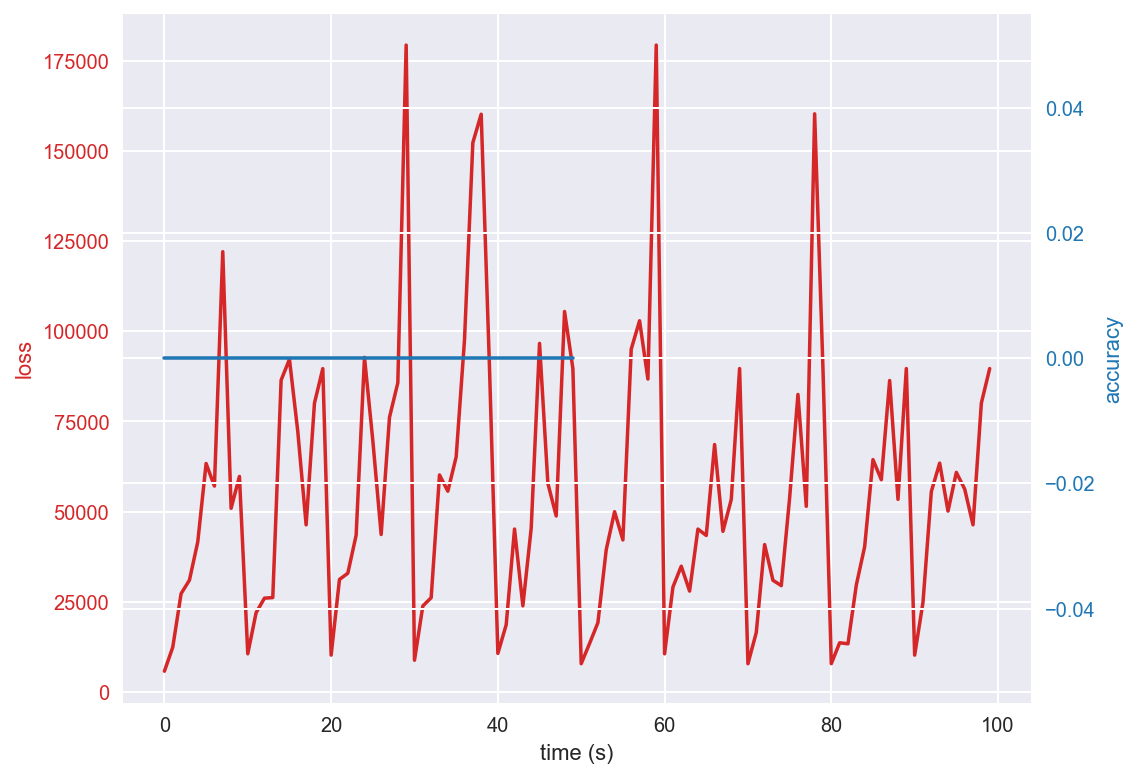

defaultdict(list,
            {'train_loss': [5787.735087683378,
              12418.015133682728,
              27276.675181845345,
              31001.93762744211,
              41611.81551635931,
              63338.382213062134,
              57077.868009737926,
              122027.00174585986,
              50920.926375279094,
              59756.53346902559,
              10609.866082731829,
              22002.446615497214,
              26025.97754685994,
              26186.255720191508,
              86430.02287822487,
              92217.78634688594,
              72197.82556159604,
              46344.176098999764,
              80060.69750341632,
              89634.77340727761,
              10245.265890548695,
              31209.846185163147,
              32931.53119074653,
              43475.96569677192,
              92739.67648314685,
              69682.42955094138,
              43676.8256847894,
              76125.10431503912,
              85699.17859405595,


In [57]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True


T = RegTagger(use_cuda=use_cuda, device=device)
T.train(batch_size=5, num_workers=0, max_epochs=10,
        splittings=splittings, labels=labels, train_val_syn=train_val_syn, data=data, embed_size=300,
        target_vocab=target_VOCAB, spatial_tags=SPATIAL_TAGS)

In [50]:
print(torch.__version__)

1.10.1


In [ ]:
sentence = ['Hundred', 'babies', 'are', 'one', 'years', 'old', '.']
sentag = T.tag(sentence, 300, target_VOCAB[:100], SPATIAL_TAGS[:100], 5)
# sentag

In [55]:
sentence = ['Hundred', 'babies', 'are', 'one', 'years', 'old', '.']
sentag = T.tag(sentence, 300, target_VOCAB[:100], SPATIAL_TAGS[:100], 5)
sentag

['Hundred', 'babies', 'are', 'one', 'years', 'old', '.']
['hundred', 'baby', 'one', 'year', 'old']
Hundred 	 ? 	 dict_items([('B', [array([['tenth', 'tenth.s.01'],
       ['1', 'one.s.01'],
       ['cv', 'one_hundred_five.s.01'],
       ['k', 'thousand.s.01'],
       ['x', 'ten.s.01']], dtype='<U76'), tensor([144843.0469, 147138.3594, 147406.2188, 149038.9531, 149611.6406],
       grad_fn=<TopkBackward0>)])])

babies 	 ? 	 dict_items([('B', [array([['tenth', 'tenth.s.01'],
       ['1', 'one.s.01'],
       ['cv', 'one_hundred_five.s.01'],
       ['k', 'thousand.s.01'],
       ['x', 'ten.s.01']], dtype='<U76'), tensor([144842.8281, 147138.2031, 147406.0312, 149038.7500, 149611.4219],
       grad_fn=<TopkBackward0>)])])

are 	 ? 	 dict_items([('B', [array([['tenth', 'tenth.s.01'],
       ['1', 'one.s.01'],
       ['cv', 'one_hundred_five.s.01'],
       ['k', 'thousand.s.01'],
       ['x', 'ten.s.01']], dtype='<U76'), tensor([144842.3281, 147137.8281, 147405.6094, 149038.2812, 149610.9219]

In [ ]:
sentence = ['Hundred', 'babies', 'are', 'one', 'years', 'old', '.']
sentag = T.tag(sentence, 300, target_VOCAB[:100], SPATIAL_TAGS[:100], 5)
sentag

In [ ]:
sentence = ['Hundred', 'babies', 'are', 'one', 'years', 'old', '.']
sentag = T.tag(sentence, 300, target_VOCAB[:100], SPATIAL_TAGS[:100], 5)
sentag

In [ ]:
k = sentag[0][0].keys()
d = sentag[1][0]
d

In [ ]:
d.fromkeys(k)

In [ ]:
# for k, val in sentag[0].items():
#     print(k)

for di in sentag[0]:
    print(type(di))
    print(di.keys())

In [ ]:
d.fromkeys(k)

In [ ]:
# for k, val in sentag[0].items():
#     print(k)

for di in sentag[0]:
    print(type(di))
    print(di.keys())

In [ ]:
t.test(testing_data=splittings[], test_syn=, batch_size=5, num_workers=0, target_vocab=target_VOCAB, spatial_tag=SPATIAL_TAGS, k=5, shuffle=True)

In [ ]:
plt.plot(history['train_loss'])
# plt.plot(history['sense_accuracy'])
# plt.legend(['training loss', 'validation accuracy'])


In [ ]:
plt.plot(history['train_loss'])
# plt.plot(history['sense_accuracy'])
# plt.legend(['training loss', 'validation accuracy'])


In [ ]:
plt.plot(history['validation_loss'])


In [ ]:
plt.plot(history['sense_accuracy'])


In [ ]:
data1 = history["train_loss"] 
data2 = history["sense_accuracy"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('loss', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

# Testing

In [ ]:
a = np.array([7,7,3])
a[]

## Sense Inference

In [ ]:
def is_contained(pred, sphere_coo, compare_spheres=False):

    pt, word = coo2point(pred)
    sphere_sense, sphere_center = coo2point(sphere_coo)

    pt_rad = pred[-1]
    sphere_rad = sphere_coo[-1] # in angles
    
    
    
    if compare_spheres == False:
        contained = (pt[0] - sphere_sense[0])**2 + (pt[1] - sphere_sense[1])**2 <= sphere_rad**2
    else:
        contained = pt_rad + torch.linalg.norm(pt - sphere_sense) - sphere_rad <= 0

    if contained:
        return True
    else:
        return False
    


def vicinity_matrix(spatial_params, target_vocab: np.ndarray, spatial_tags: np.ndarray, k=5):#, include_sphere=True, include_r=True) -> [str]:
    """
    Projects the predicted spatial parameters into the embedding space.
    Returns the synsets in the vicinity of the projected point.
    :param spatial_params:
    :return: Vicinity matrix, synsets dict
    """
    N = len(spatial_tags)
    
    #convert spatial_tags to tensor
    spatial_tags = torch.from_numpy(spatial_tags)
    
    synsets = {} # sort from most specific to most general
    
    indices = {}

    sense_pt, center_pt = coo2point(spatial_params)
    
    # ----------------------------------------------------------------------------------------------------------------
    # Prepare distance and containment calculations
    # ----------------------------------------------------------------------------------------------------------------
    
    # distance calculations
    dist_spheres = torch.empty(N) 
    dist_pt_sphere = torch.empty(N) 
    dist_pts = torch.empty(N)
    
    for i, tag in enumerate(spatial_tags):
        dist_spheres[i] = distance_loss(spatial_params, tag, include_r=True)
        dist_pt_sphere[i] = distance_loss(spatial_params, tag, pt_sphere=True)
        dist_pts[i] = distance_loss(spatial_params, tag, include_r=False)
    
    # containment calculations
    full_contained = torch.empty(N) 
    part_contained = torch.empty(N)
    disconnected = torch.empty(N) # handles points only
    
    for j, tag in enumerate(spatial_tags):
        full_contained[j] = is_contained(spatial_params, tag, compare_spheres=True)
        part_contained[j] = distance_loss(spatial_params, tag, include_r=True) > 0
        disconnected[j] = ~ is_contained(spatial_params, tag, compare_spheres=True) # reverse the True <----> False
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initialize the Vicinity Matrix
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # row=3, col=3, topk=2, 2 indicates the column of indices and the distances
    vicinity_matrix = torch.zeros((3,3, k, 2))
    
    ####################################################################################################################
    # # Full contained + min dist between sense points
    ####################################################################################################################
    
    print("True elements")
    true_indices1 = (full_contained == True).nonzero(as_tuple=True)[0]
    print(true_indices1)
    
    if true_indices1.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices1)
        print("dist1", dist1)
        print("k = ", k)
        # sort in ascending order
        # select top k 
        sort_dist1, sort_indices = torch.topk(dist1, k, largest=False)  
        print("SORTING", sort_dist1, sort_indices)
        synsets1 = np.take(target_vocab, sort_indices, 0)
        synsets["A"] = synsets1
        indices["A"] = sort_indices
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][0] = torch.stack((sort_indices, sort_dist1), dim=1)
    else:
        pass
    
    
    ####################################################################################################################
    # # Partially contained + min dist between sense points
    ####################################################################################################################
    true_indices2 = (part_contained == True).nonzero(as_tuple=True)[0]
    print("True Indices 2", true_indices2)
    
    if true_indices2.size(0) != 0:
        dist1 = torch.index_select(dist_pts, 0, true_indices2)
        # sort in ascending order
        # select top k 
        sort_dist2, sort_indices2 = torch.topk(dist1, k, largest=False)     
        synsets2 = np.take(target_vocab, sort_indices2, 0)
        print("synset 2", synsets2)
        synsets["B"] = synsets2
        indices["B"] = sort_indices2
        # index, distance (without synsets because this would result in conflicts for torch.tensor that do not support str)
        vicinity_matrix[2][1] = torch.stack((sort_indices2, sort_dist2), dim=1)
    else:
        pass

    ####################################################################################################################
    # # Disconnected + min dist between spheres/point2sphere/sense points ---> acts as Nearest neighbor
    ####################################################################################################################
    # get indices, where disconnected is true
    true_indices3 = (disconnected == True).nonzero(as_tuple=True)[0]
    print("True Indices 3", true_indices3)

    if true_indices3.size(0) != 0:
        # get the distances at those indices
        dist_spheres3 = torch.index_select(dist_spheres, 0, true_indices3)
        dist_pt_sphere3 = torch.index_select(dist_pt_sphere, 0, true_indices3)
        dist_pts3 = torch.index_select(dist_pts, 0, true_indices3)

        # sort-select top k minimum distances
        sort_dist_spheres3, sort_sph_indices3 = torch.topk(dist_spheres3, k, largest=False)
        sort_dist_pt_sphere3, sort_pt_sph_indices3 = torch.topk(dist_pt_sphere3, k, largest=False)
        sort_dist_pts3, sort_pts_indices3 = torch.topk(dist_pts3, k, largest=False)

        # get their corresponding synsets
        synsets30 = np.take(target_vocab, sort_sph_indices3, 0)
        #print("synset30", synsets30)
        synsets["C"] = synsets30
        indices["C"] = sort_sph_indices3
        
        synsets31 = np.take(target_vocab, sort_pt_sph_indices3, 0)
        synsets["D"] = synsets31
        indices["D"] = sort_pt_sph_indices3
        
        synsets32 = np.take(target_vocab, sort_pts_indices3, 0)
        synsets["E"] = synsets32
        indices["E"] = sort_pts_indices3
        
        # insert them into the vicinity matrix    
        vicinity_matrix[0][3] = torch.stack((sort_sph_indices3, sort_dist_spheres3), dim=1)
        vicinity_matrix[1][3] = torch.stack((sort_pt_sph_indices3, sort_dist_pt_sphere3), dim=1)
        vicinity_matrix[2][3] = torch.stack((sort_pts_indices3, sort_dist_pts3), dim=1)  
    


#     # get the spheres, where the point/point+radius is contained/overlaping/near

#     # 1. check if the predicted point is contained in some sense
#     contained = torch.empty(N)
    
#     for i, tag in enumerate(spatial_tags):
#         contained[i] = is_contained(spatial_params, tag, compare_spheres=include_sphere)
    
#     # 2. For those synsets, which is the nearest synset point
#     #use distance() to calculate distance between centers
#     distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         distances[i] = distance_loss(spatial_params, tag, include_r=include_r)
    
#     # sort dist--> indices
#     # check if for those distances the containment is true
#     # if true: choose the one having min_dist as sense
#     # top k senses must be stored in a dict 
    
#     # check if for those distances the containment is false, then, only the radius is falsly predicted (not priority now)
#     # if false and min_dist: choose it as potential sense
    
    

#     # 3. If None of the synsets apply to that word sense
#     # use sphere_dist to find the nearest sphere (most general synset), and assign it to that synset
#     # (this maybe good for rare senses)
#     # acts as a second chance
#     rare_contained = torch.empty(N)
#     rare_distances = torch.empty(N)
#     for i, tag in enumerate(spatial_tags):
#         rare_contained[i] = is_contained(spatial_params, tag, compare_spheres=False) #only consider sense point
#         rare_distances[i] = distance_loss(spatial_params, tag, include_r=False)


    return indices, vicinity_matrix, synsets

def decode_key(key, mtx):
    if key == "A":
        return mtx[2, 0]
    if key == "B":
        return mtx[2, 1]
    if key == "C":
        return mtx[0, 2]
    if key == "D":
        return mtx[1, 2]
    if key == "E":
        return mtx[2, 2]
    

def label_in_vicinity(vicinity_matrix, vicinity_synsets, target_vocab, spatial_tags, true_label):
    
    checked_synsets = []
    contained = []
    checks = 0
    predicted = []
    distances = []
    
    in_vicinity = False
    
    # true label is either one of the possibilities [word, synset] or a randomly chosen one
    
    # induce subset of word-synset name 
    
    #spatial_tags = torch.from_numpy(spatial_tags)
    #idx_label = (spatial_tags == true_label).nonzero(as_tuple=True)[0]
    # transform to numpy to 
    true_label = np.array(true_label, dtype=np.float64)
    # keep spatial tag an np.ndarray
    rounded_l = np.round(true_label, decimals=2)
    try:
        # detecting the true label from the spatial_tags
        idx = [[np.array_equal(rounded_l, tag) for tag in spatial_tags].index(True)]
        print("Found {} matching word-synset tags.".format(len(idx)))
        word_synset = target_vocab[idx] #list of list 
        print("Matching word-synset", word_synset)
        # check if word_synset is within the vicinity matrix
        if len(word_synset) != 0:
            for e in word_synset:
                for key, val in vicinity_synsets.items():
                    print("Searching in vicinity ... ")

                    print("Checking if true label is in vicinity ...")
                    checked_synsets.append(e)
                    is_there = e[1] in val[:, 1]
                    checks += 1
                    contained.append(is_there)
                    
#                     print("1")
#                     print(checked_synsets)
#                     print(checks)
#                     print(contained)
                    
                    if is_there:
                        print("The main true label <{}> is in the vacinity of the predicted tag.".format(e))
                        idx_e = np.where(val[:, 1] == e[1])
                        predicted.append(val[idx_e])
#                         print("Predicted 1: ", predicted)
                        distances.append(decode_key(key, vicinity_matrix)[idx_e][1])
#                         print("Distances 1: ", distances)
                    else:
                        print("The main true label is not in vicinity ... ")
                        distances.append(0.0)
                        print("Searching if alternative true label synsets are in vicinity ... ")
                    # induce all the word-synset tuples that have same synset as true label.
                    # This double check is necessary since I choose the spatial tags in the training data randomly sometimes.
                    # get indices of all word-synsets sharing same synset (not same word)
                    ix = np.where(target_vocab == [_, e[1]])[0] # add [0] to indicate only the row index, not the column
#                     print("Indices ", ix)
                    if len(ix) != 0:
                        pos_syn = target_vocab[ix]
                        
#                         print("Possible synsets: ", pos_syn)
#                         print(target_vocab[:10])
                        for t in pos_syn:
                            checks += 1
                            checked_synsets.append(t)
                            is_near = t[1] in val[:, -1]
                            contained.append(is_near)
#                             print("2")
#                             print(checked_synsets)
#                             print(checks)
#                             print(contained)
                            if is_near == True:                                    
                                print("... The word-synset <{}> is in the vicinity of the predicted tag.".format(t))
                                idx_t = np.where(val[:, -1] == t[1])
                                predicted.append(val[idx_t])
#                                 print("Predicted 2: ", predicted)
                                distances.append(decode_key(key, vicinity_matrix)[idx_t][1])
#                                 print("Distances 2: ", distances)
                            else:
                                distances.append(0.0)
                    else: 
                        print("... There are no other possibilites for word-synset <{}>".format(e))
                            
        else:
            print("Cannot find the suitable synset of this spatial tag!")

        
    except ValueError as ve:
        print(ve)
        print("Found no index for the true label. Something went wrong ...")
        print("Comparing <true label = {}> with <rounded label = {}>".format(true_label, rounded_l))
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Statistics
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    print("~" * 80)
    print("Statistics")
    print("~" * 80)
    
#     print("Predicted Spatial Tag = ", spatial_params)
    print("Checked Spatial Tag(s) ; contained? ; Predicted ; distances = ({}):".format(len(checked_synsets)))
    for s, c, p, d in zip(checked_synsets, contained, predicted, distances):
        print(s, ";", c, ";", "\n", p, ";", d)
        print("-"*100)
        
#     print("True Spatial Tag(s) is in vicinity of predicted tag: ", contained)
    contained_idx = np.where(np.array(contained) == True)
    
#     print("contained_idx", contained_idx)
#     print("checked_idx", np.array(checked_synsets)[contained_idx])
#     print("slice", np.array(checked_synsets)[:, 1])
#     print("check_slice", np.array(checked_synsets)[:, 1][contained_idx])

    if len(contained_idx) != 0:
        print()
        only_syn = set(np.array(checked_synsets)[contained_idx][:, 1])
        print("True Sense Tag(s) = ({}) ..".format(len(only_syn)), only_syn)
        print("Prediction is correct!")
        in_vicinity = True
#         print("Distance(predicted_sense, nearest_true_sense) = ({}): ".format(len(np.array(predicted)[contained_idx])))
#         for p, d in zip(np.array(predicted), distances):
#               print(p, d)
              
    else:
        print("Prediction is false ..")
        print("All synsets in the vicinity of the predicted tag are not true senses ..")
        print("Please check manually if the synsets in the vicinity are generalizations of the true labels.")
        in_vicinity = False
    
    
    return checked_synsets, contained, checks, predicted, distances
    
    

In [ ]:
i = np.where(target_VOCAB==[_,"boat.n.01"])[0]
SPATIAL_TAGS[i]


In [ ]:
i

In [ ]:
target_VOCAB[i]

In [ ]:
print(target_VOCAB[60])
print(SPATIAL_TAGS[60])


In [ ]:
params = torch.tensor([34035, 78.06, 174780, 0.0, 64.5]) # synset boat

# I created this synset for thousand.n.01, at index 60, word is 'thou'
sample_tag = torch.tensor([36670, 100.07, 180000.00, 0.0, 1.6])
true_lab = torch.tensor(SPATIAL_TAGS[60])

idx, mat, syn = vicinity_matrix(spatial_params=sample_tag, target_vocab=target_VOCAB[:100], spatial_tags=SPATIAL_TAGS[:100], k=5)

In [ ]:
syn

In [ ]:
# e = np.array(['thou', 'thousand.n.01'])
e = np.array(["thou", "thousand.n.01"])
val = np.array([['k', 'thousand.n.01'], ['c', 'hundred.n.01'], ['i', 'one.n.01'], ['ks', 'thousand.n.01'], ['cs', 'hundred.n.01']])
e in val 
idx_e = np.where(val == e)
idx_e

In [ ]:
s =np.where(val[:, 1] == e[1])
val[s]

In [ ]:
co = np.array([True, False, True])

co[np.where(co==True)]

In [ ]:
csyn, cont, ch, pred, dist = label_in_vicinity(vicinity_matrix=mat, vicinity_synsets=syn, 
                      target_vocab=target_VOCAB[:100], spatial_tags=SPATIAL_TAGS[:100], true_label=true_lab)

In [ ]:
dist

In [ ]:
poss = []
dis = []
for p, d in zip(pred, dist):
    print("There are {} true values in the vicinity of predicted tag.".format(len(p)))
    if len(p) > 0:
        for i in range(len(p)):
            is_in = p[i] in poss
            if is_in:
                continue
            else:
                poss.append(p[i])
                dis.append(d[i])
    print(poss)
    print(dis)
    
#     if p in poss:
#         continue
#     else:
#         poss.append(p)
#     if d in dis:
#         continue
#     else:
#         dis.append(d)
        
        
for p,d in zip(poss, dis):
    print(p, d)

In [ ]:
len(pred)

In [ ]:
cont

In [ ]:
ch

In [ ]:
csyn

In [ ]:
spatial_params = torch.tensor([111740.0, 98.3, 980130.0, 0.0, 18.5], dtype=torch.float64)
# df=spatial_wordnet
# st = list(zip(df.l0, df.alpha, df.l_i, df.beta_i, df.radius))
# df.loc[df['l0'] == 111740.0]

In [ ]:
# The problem here was that there is transforming from torch to numpy leads to failures in rounding
s = np.array(data[0][2][2], dtype=np.float64)
print(s)
spatial_params = np.array([1.351440e+05, 2.501000e+01, 6.417603e+04, 9.000000e+01, 5.000000e-01])
print("spatial_params", spatial_params)
# index = np.where(SPATIAL_TAGS==spatial_params)
# len(index[0])
# len(SPATIAL_TAGS)
sr = np.round(s, decimals=2)
pr = np.round(spatial_params, decimals=2)
print("rounded spatial_params", pr)
idx = [np.array_equal(pr,x) for x in SPATIAL_TAGS].index(True)
idx


In [ ]:
idx = [13, 304]
target_VOCAB[idx]

In [ ]:
np.where(target_VOCAB == [_, 'dog.n.01'])

In [ ]:
target_VOCAB[111115]

In [ ]:
tp = data[0][2][2]
print("torch tensor:", tp)
tpr = torch.round(tp)
print("rounded:", tpr)
ttags = torch.from_numpy(SPATIAL_TAGS) 
print(ttags[50801])
# torch.nonzero((ttags == tp).sum(dim=1) == ttags.size(1))
torch.all(ttags == tpr)#, x=1)

In [ ]:
#spatial_params = torch.tensor([143500, 6.8500, 7574.6, 0.0, 0.5])
torch.nonzero((torch.from_numpy(SPATIAL_TAGS) == spatial_params).sum(dim=1) == torch.from_numpy(SPATIAL_TAGS).size(1))

In [ ]:
#spatial_params = torch.tensor([143500, 6.8500, 7574.6, 0.0, 0.5])
torch.nonzero((torch.from_numpy(SPATIAL_TAGS) == spatial_params).sum(dim=1) == torch.from_numpy(SPATIAL_TAGS).size(1))

In [ ]:
torch.all(torch.from_numpy(SPATIAL_TAGS) == spatial_params, x=1)

In [ ]:
torch.from_numpy(SPATIAL_TAGS[0])

In [ ]:
spatial_params = torch.tensor([111740.0, 98.3, 980130.0, 0.0, 18.5])
c0 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[0]).nonzero(as_tuple=True)
print(c0)
c1 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[1]).nonzero(as_tuple=True)
print(c1)
c2 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[2]).nonzero(as_tuple=True)
print(c2)
c3 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[3]).nonzero(as_tuple=True)
print(c3)
c5 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[4]).nonzero(as_tuple=True)
print(c5)
# for i in c[1]:
#     if i != 3:
#         print(i)

In [ ]:
torch.where(torch.from_numpy(SPATIAL_TAGS)== spatial_params)

In [ ]:
torch.where(torch.from_numpy(SPATIAL_TAGS)== spatial_params)

In [ ]:
params = torch.tensor([34035, 78.06, 174780, 0.0, 64.5]) # synset boat

idx, mat, syn = vicinity_matrix(spatial_params=params, target_vocab=target_VOCAB[:20], spatial_tags=SPATIAL_TAGS[:20], k=5)
syn

In [ ]:
idx

In [ ]:
mat

In [ ]:
tp = data[0][2][2]
print("torch tensor:", tp)
tpr = torch.round(tp)
print("rounded:", tpr)
ttags = torch.from_numpy(SPATIAL_TAGS) 
print(ttags[50801])
# torch.nonzero((ttags == tp).sum(dim=1) == ttags.size(1))
torch.all(ttags == tpr)#, x=1)

In [ ]:
#spatial_params = torch.tensor([143500, 6.8500, 7574.6, 0.0, 0.5])
torch.nonzero((torch.from_numpy(SPATIAL_TAGS) == spatial_params).sum(dim=1) == torch.from_numpy(SPATIAL_TAGS).size(1))

In [ ]:
#spatial_params = torch.tensor([143500, 6.8500, 7574.6, 0.0, 0.5])
torch.nonzero((torch.from_numpy(SPATIAL_TAGS) == spatial_params).sum(dim=1) == torch.from_numpy(SPATIAL_TAGS).size(1))

In [ ]:
torch.all(torch.from_numpy(SPATIAL_TAGS) == spatial_params, x=1)

In [ ]:
torch.from_numpy(SPATIAL_TAGS[0])

In [ ]:
spatial_params = torch.tensor([111740.0, 98.3, 980130.0, 0.0, 18.5])
c0 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[0]).nonzero(as_tuple=True)
print(c0)
c1 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[1]).nonzero(as_tuple=True)
print(c1)
c2 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[2]).nonzero(as_tuple=True)
print(c2)
c3 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[3]).nonzero(as_tuple=True)
print(c3)
c5 = (torch.from_numpy(SPATIAL_TAGS)==spatial_params[4]).nonzero(as_tuple=True)
print(c5)
# for i in c[1]:
#     if i != 3:
#         print(i)

In [ ]:
torch.where(torch.from_numpy(SPATIAL_TAGS)== spatial_params)

In [ ]:
torch.where(torch.from_numpy(SPATIAL_TAGS)== spatial_params)

In [ ]:
params = torch.tensor([34035, 78.06, 174780, 0.0, 64.5]) # synset boat

idx, mat, syn = vicinity_matrix(spatial_params=params, target_vocab=target_VOCAB[:20], spatial_tags=SPATIAL_TAGS[:20], k=5)
syn

In [ ]:
idx

In [ ]:
mat

In [ ]:
mat[2,1]

In [ ]:
for k, v in syn.items():
    print(k,v)

In [ ]:
torch.tensor([]).size(0)

In [ ]:
if not torch.all(torch.eq(spatial_params, torch.zeros(spatial_params.size(0))), dim=0):
    print("hi")

In [ ]:
t = torch.tensor([True, False, False, True, True])
(t == True).nonzero(as_tuple=True)[0]

In [ ]:
ts = torch.tensor([12, 89, -2, 0.2])
torch.sort(ts)

In [ ]:
topk = torch.topk(ts, 3, largest=False)
topk

In [ ]:
sy = np.array(["a", "b", "c", "d"])

np.take(sy, topk[1], 0)

In [ ]:
row = 3
col = 3
k = 3
t = 2
vicinity_matrix = torch.empty((row, col, k, t))
print(vicinity_matrix)
print(vicinity_matrix[2][0])
# newt = torch.tensor(topk[1], topk[0])
# print(newt)
# vicinity_matrix[2, 0] = torch.stack((torch.topk[1], torch.topk[0]), dim=-1)
print(vicinity_matrix[2][0])
    

## Geometric Loss

In [ ]:
# write a custom loss function in pytorch for 
# I need a fct to transform 5 coordinates into 2
# and another function to calculate the loss between 2 points, then the total loss is the loss of all losses in a sentence 


def coo2point(coo):
    print(coo)
    l0 = coo[0]
    alpha = coo[1]
    alpha_rad = alpha * math.pi / 180
    l_i = coo[2]
    beta_i = coo[3]
    beta_i_rad = beta_i * math.pi / 180
    r = coo[4]
    
    # np.cos() and np.sin() take angles in radian as params
    center_pt = torch.tensor([l0 * math.cos(alpha_rad), l0 * math.sin(alpha_rad)], dtype=torch.float64, requires_grad=True)
    sense_pt = center_pt + torch.tensor([l_i * math.cos(alpha_rad + beta_i_rad),
                                     l_i * math.sin(alpha_rad + beta_i_rad)], dtype=torch.float64, requires_grad=True)
    return sense_pt, center_pt




def distance_loss(pred_pt, original_pt, include_r=False, pt_sphere=False):
    """
    Calculates the distance between two sense points, including radii.
    :param pred_pt:
    :param original_pt:
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return:
    """
        
    # original_pt = torch.from_numpy(original_pt)
    # print("original point", type(original_pt), original_pt)
    
    r1 = pred_pt[-1]
    r2 = original_pt[-1]

    pred_sense, pred_center = coo2point(pred_pt)
    orig_sense, orig_center = coo2point(original_pt)
    
    
    loss = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) - r2
    
    # very strong assumption for the words that are not sense-tagged
    # If I want more tolerance, I could neglect those tokens from the beginning
    if torch.all(torch.eq(original_pt, torch.zeros(original_pt.size(0))), dim=0):
        return loss
    
    if pt_sphere:
        dist = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) + r2
        return dist

    
    if include_r:
        
        tolerant_loss = r1 + loss - r2
    
        if tolerant_loss < 0:
            tolerant_loss = 0.0
        
#         if r1 > r2: #case the predicted radius is bigger than actual one
#             tolerant_loss = torch.abs(torch.sub(r1, r2))
           
        return tolerant_loss
    
    else:
        return loss 
   


def geometric_loss(pred_list, label_list, include_r=False):
    
    # assert that the two lists must be of equal size
    pred_size = pred_list.size()[0]
    lab_size = label_list.size()[0]
    assert pred_size == lab_size
    
    sentence_loss = 0.0
    
    # sum over all the tokens in the sentence
    for i in range(pred_size):
        sentence_loss += distance_loss(pred_list[i], label_list[i], include_r)
        
    return sentence_loss

In [ ]:
example = torch.tensor([2.8, 45, 1.4, 0, 3.5])
example2 = torch.tensor([0.0,0.0,0.0,0.0,0.0])
geometric_loss(example, example2, include_r=False)

In [ ]:
example = torch.tensor([2.8, 45, 1.4, 0, 3.5])
example2 = torch.tensor([0.0,0.0,0.0,0.0,0.0])
geometric_loss(example, example2, include_r=False)

In [ ]:
sy = np.array(["a", "b", "c", "d"])

np.take(sy, topk[1], 0)

## Geometric Loss

In [ ]:
# write a custom loss function in pytorch for 
# I need a fct to transform 5 coordinates into 2
# and another function to calculate the loss between 2 points, then the total loss is the loss of all losses in a sentence 


def coo2point(coo):
    print(coo)
    l0 = coo[0]
    alpha = coo[1]
    alpha_rad = alpha * math.pi / 180
    l_i = coo[2]
    beta_i = coo[3]
    beta_i_rad = beta_i * math.pi / 180
    r = coo[4]
    
    # np.cos() and np.sin() take angles in radian as params
    center_pt = torch.tensor([l0 * math.cos(alpha_rad), l0 * math.sin(alpha_rad)], dtype=torch.float64, requires_grad=True)
    sense_pt = center_pt + torch.tensor([l_i * math.cos(alpha_rad + beta_i_rad),
                                     l_i * math.sin(alpha_rad + beta_i_rad)], dtype=torch.float64, requires_grad=True)
    return sense_pt, center_pt




def distance_loss(pred_pt, original_pt, include_r=False, pt_sphere=False):
    """
    Calculates the distance between two sense points, including radii.
    :param pred_pt:
    :param original_pt:
    :param include_r: if set to true, include radius in the distance. 
                      It gives more freedom/tolerance degrees to the loss function. 
                      Loss is satisfied once the predicted point is part of original point.
    :return:
    """
        
    
    r1 = pred_pt[-1]
    r2 = original_pt[-1]

    pred_sense, pred_center = coo2point(pred_pt)
    orig_sense, orig_center = coo2point(original_pt)
    
    
    loss = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) - r2
    
    # very strong assumption for the words that are not sense-tagged
    # If I want more tolerance, I could neglect those tokens from the beginning
    if torch.equal(original_pt, torch.zeros(original_pt.size()[0])):
        return loss
    
    if pt_sphere:
        dist = torch.linalg.norm(torch.sub(pred_sense, orig_sense)) + r2
        return dist

    
    if include_r:
        
        tolerant_loss = r1 + loss - r2
    
        if tolerant_loss < 0:
            tolerant_loss = 0.0
        
#         if r1 > r2: #case the predicted radius is bigger than actual one
#             tolerant_loss = torch.abs(torch.sub(r1, r2))
           
        return tolerant_loss
    
    else:
        return loss 
   


def geometric_loss(pred_list, label_list, include_r=False):
    
    # assert that the two lists must be of equal size
    pred_size = pred_list.size()[0]
    lab_size = label_list.size()[0]
    assert pred_size == lab_size
    
    sentence_loss = 0.0
    
    # sum over all the tokens in the sentence
    for i in range(pred_size):
        sentence_loss += distance_loss(pred_list[i], label_list[i], include_r)
        
    return sentence_loss

In [ ]:
example = torch.tensor([2.8, 45, 1.4, 0, 3.5])
example2 = torch.tensor([0.0,0.0,0.0,0.0,0.0])
geometric_loss(example, example2, include_r=False)

In [ ]:
l = torch.tensor([[2.8, 45, 1.4, 0, 3.5], [2124, 90, 1000, 14, 0.5]])
l.view(-1)
l.size()

In [ ]:
print(torch.__file__)

In [ ]:
# <span style="color:red"> WSD as Classification Task 

# <span style="color:red"> WSD as Classification Task 

In [ ]:
class TransformerEncoderModel(nn.Module):

    def __init__(self, weights_matrix:np.ndarray, target_matrix: np.ndarray,
                 ntoken: int, out_features:int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        
        super().__init__()
        
        self.model_type = 'Transformer'
        
        self.d_model = d_model
        
        self.weights_matrix = weights_matrix
        
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Embedding layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(self.weights_matrix, True)
        
        # Multi-head attention mechanism is included in TransformerEncoderLayer
        # d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=<function relu>, 
        # layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout) # activation
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers, norm=None)
        
        
#         padding_idx (int, optional) – If specified, the entries at padding_idx do not contribute to the gradient;
#         therefore, the embedding vector at padding_idx is not updated during training,
#         i.e. it remains as a fixed “pad”. For a newly constructed Embedding, the embedding vector at
#         padding_idx will default to all zeros, but can be updated to another value to be used as the padding vector.
        self.emb = nn.Embedding(ntoken, d_model) 
        self.out_features = out_features
        
        # Linear layer: returns the last hidden state of the encoder 
        self.fc = nn.Linear(d_model, embedding_dim)
        
        # No! Here I am just redoing fully connected connections
        # Linear Layer: affine transformation of last hidden layer into shape (1, embedding_dim)
        #self.context_vec = nn.Linear(d_model, embedding_dim)
        
        #self.decoder = nn.Linear(d_model, ntoken)
        
        # Now, I need to have a Linear space that takes the whole/subset dataframe as input, extracts its spatial_context_vec,
        # based on Glove-word-vector + spatial_point,
        # then calculates softmax on this distribution
        # choose the argmax
        # get its spatial tags
        # calculate distance loss between them
        # do backprop! 
        # Nx300 into Nx227733: matmul product of two matrices Nx300 and 300x227733 --> Nx227733
        # apply softmax to get the probabilities
        # apply argmax to get the maximum indices
        # use the indices to get the synset names as well as the mapping to coordinates
        # into Nx5: mapping to the coordinates
        
        self.target_matrix = target_matrix
        
        #self.wn_embeddings = nn.Linear(1, target_matrix.shape[0])

        self.init_weights()
        
#         weights_matrix = weights_matrix, 
#                                     ntoken= # false: 300,
#                                     out_features=5,
#                                     d_model=300,
#                                     d_hid=200,
#                                     nlayers=2,
#                                     nhead=2,
#                                     dropout=0.2
        
        
        # -------------------------------------

        # voc_size = len(text_field.vocab)
        # print("voc_size: ", voc_size )
        #
        # # Embedding layer. If we're using pre-trained embeddings, copy them
        # # into our embedding module.
        # self.embedding = nn.Embedding(voc_size, 300)
        # print("Embedding", self.embedding)
        # if text_field.vocab.vectors is not None:
        #     self.embedding.weight = torch.nn.Parameter(TEXT.vocab.vectors)


    def init_weights(self) -> None:
        initrange = 0.1
        self.emb.weight.data.uniform_(-initrange, initrange)
        # self.decoder.bias.data.zero_()
        # self.decoder.weight.data.uniform_(-initrange, initrange)
        
        #self.output.bias.data.zero_()
        #self.output.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        
        #src = self.encoder(src) * math.sqrt(self.d_model)
        src = torch.mul(self.emb(src), math.sqrt(self.d_model)) #? 1/sqrt!
        print("Embedding", src.shape)
        print('-' * 80)
        
        
        src = self.pos_encoder(src)
        print("Positional Encoding", src.shape)
        print('-' * 80)
        
        
        encoder_output = self.transformer_encoder(src) #, src_mask)
        print("Encoder", encoder_output.shape)
        print(encoder_output)
        print('-' * 80)
        
        
        linear_layer = self.fc(encoder_output)
        print("Linear Layer", linear_layer.shape)
        print(linear_layer)
        print('-' * 80)

        # calculate the sum/weighted sum/ ?? on the linear layer to get the context vector of size (1, embd_dim)
        context_vec = torch.sum(linear_layer, dim=1)
        print("Final Context Vector", context_vec.shape)
        print(context_vec)
        print('-' * 80)
        
        # calculate the matrix that transforms a context vector into all wordnet embeddings
        # expected: Nx223377x300
#         wn_layer = self.wn_embeddings(context_vec)
#         print("WordNet Embedding", wn_layer.shape)
#         print(wn_layer[0])
#         print('-' * 80)
        
        # there must be a calculation here with the 
        # calculate dot product
        # dim -1 is dim = 2 in 1[1[1[]],2[],..., N[]] 
        #trans_context_vec = torch.transpose(context_vec, 0, 1)
        sense_matrix = torch.from_numpy(self.target_matrix).float()
        print("sense mat", sense_matrix.shape)
        print(sense_matrix[0])
        trans_sense_matrix = torch.transpose(sense_matrix, 0, 1)
#         dot_prod = torch.sum(torch.matmul(context_vec, trans_sense_matrix), dim=-1)
        dot_prod = torch.matmul(context_vec, trans_sense_matrix)

        print("Dot Product", dot_prod.shape)
        print(dot_prod)
        print('-' * 80)
        
        
        # calculate softmax
        # expected Nx 227733
        softmax = F.softmax(dot_prod)
        print("Softmax", softmax.shape)
        print(softmax)
        print('-' * 80)
        
        # argmax
        max_match = torch.argmax(softmax, dim=1) # dim 1 to indicate row
        # expected Nx1
        print("argmax", max_match.shape)
        print(max_match)
        print('-' * 80)
        
        # calculate softmax on all 
        
        #dec = self.decoder(output)
        #print("Decoder")
        #print(dec.shape)
        #print(dec)
        return max_match


In [ ]:
history = defaultdict(list)

VOCAB, weights_matrix = load_vocab(data, embed_size=300)

# target_VOCAB
# SPATIAL_TAGS

n_epochs = 3

# Loop over epochs
for epoch in range(max_epochs):
    
    
    model = TransformerEncoderModel(weights_matrix = weights_matrix, 
                                    target_matrix = tsense_matrix,
                                    ntoken= len(VOCAB), #300,
                                    out_features=5,
                                    d_model=300,
                                    d_hid=200,
                                    nlayers=2,
                                    nhead=2,
                                    dropout=0.2)
    model.to(device)

    # ---------------------------------------------------------------------
    #                       Optimizer
    # ---------------------------------------------------------------------
    criterion = nn.CrossEntropyLoss()
    lr = 5.0  # learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    # -------

    t0 = time.time()

    loss_sum = 0

    model.train()

    # for transformer
    scheduler.step()



    # Training
    for batch in training_generator:
        
        for local_batch, local_labels in batch:
            
            # Transform list(<string>) to Tensor(<Tensor>)
            print("Input Sentence")
            print(local_batch)
            input_words = local_batch
            local_batch = numericalize(local_batch, VOCAB)
            print(type(local_batch), local_batch)
            
            
            # Transform List(<Tensor>) to Tensor(<Tensor>)
            # I have labels of same length --> this should be no problem for Tensor
            local_labels = torch.stack(local_labels)
            print("Labels")
            print(type(local_labels), len(local_labels), type(local_labels[0]))
            print(local_labels)
            
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            # out outputs the indices of wordnet database
            out = model(local_batch)
            print(type(out), out.shape)
            # predicted synsets
            word_synset_list = list(map(target_VOCAB.__getitem__, out))
            print("Current Predictions")
            print("*" * 100)
            for i in range(len(input_words)):
                print("<{}> predicted as {}".format(input_words[i], word_synset_list[i]))
            #print_pred = '\n'.join('{} predicted as {}' for _, _ in zip(range(len(input_words)), range(len(word_synset_list)))).format(*input_words, *word_synset_list)
            #print(print_pred)
            #print("<{}> predicted as {}".format(zip(input_words, word_synset_list)))
            print("*" * 100)
            
            tags = list(map(SPATIAL_TAGS.__getitem__, out))
            # tags is a list of arrays of 5 parameters
            print("Spatial Tags", len(tags))
            
            ntokens = len(VOCAB)#300
            #loss = criterion(out.view(-1, ntokens), local_labels)
            # ignore prediction for the words that have no entry in the system? [0,0,0,0,0]
            loss = distance_loss()
            
            optimizer.zero_grad()
            loss.backward()
            # I added this
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            # ---
            optimizer.step()
            loss_sum += loss.item()


            train_loss = loss_sum / len(local_batch)
            history['train_loss'].append(train_loss)



            
#         # Validation
#         with torch.set_grad_enabled(False):
#             for local_batch, local_labels in validation_generator:
#                 # Transfer to GPU
#                 local_batch, local_labels = local_batch.to(device), local_labels.to(device)

#                 # Model computations
#                 [...]

# Trials

In [ ]:
# X, y = training_set.__getitem__(0)
for batch in training_generator:
    print(len(batch))
    for local_batch, local_label in batch:
        print(local_batch, local_label)

In [ ]:
# normalize each label
sent_labels = torch.tensor([[8.5479e+04, 6.0380e+01, 1.2985e+05, 9.5740e+01, 5.0000e-01],
                            [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
                            [1.2943e+05, 1.7871e+02, 2.0605e+04, 0.0000e+00, 5.0000e-01],
                            [1.3514e+05, 2.5010e+01, 6.4176e+04, 9.0000e+01, 5.0000e-01]])
norm_sent_labels = torch.nn.functional.normalize(sent_labels, p=2.0, dim=1)
norm_sent_labels

In [ ]:
sent_labels
# sent_labels[0]

In [ ]:
torch.transpose(sent_labels, 0, 1)

In [ ]:
# Output tensor
out = torch.tensor([
        [[-1.0549, -0.1433, -0.1394, -0.6256,  0.4749],
         [-0.0305,  0.0031,  0.0382, -0.0017,  0.5000],
         [ 0.5141, -0.0154, -0.3072,  0.4833,  0.3565],
         [ 0.9379,  0.5004,  0.1174,  0.0816, -0.2704]],

        [[-0.9528,  0.0359, -0.3091, -0.1796,  0.3259],
         [ 0.2951,  0.0628, -0.1382, -0.0146,  0.2808],
         [ 0.6864,  0.7282, -0.6748,  0.7032,  0.3163],
         [ 1.1643,  0.3034,  0.2858,  0.0823, -0.5213]],

        [[-0.3433,  0.7988, -0.9953, -0.2597,  0.6321],
         [ 0.0388, -0.5481, -0.2017, -0.2700,  0.4406],
         [ 0.9477,  0.4574, -0.2327,  0.0848,  0.3336],
         [ 0.2500,  0.2523,  0.3734,  0.7667, -0.3530]],

        [[-0.7934,  0.4223, -0.1750, -0.5049,  0.6555],
         [ 0.0534, -0.6308, -0.7725, -0.3165,  0.3568],
         [ 0.3805,  0.2004, -0.3675,  0.2600,  0.2836],
         [-0.0449, -0.0765, -0.2250,  0.9507,  0.1856]]
])


In [ ]:
# Nx300 [[1, ..., 300], ... , N[]] * [[1, ..., 300], ..., 227733[]]
# from 4x5 to 4x20x5
N = 1
n = 5
tensor = torch.rand(20, n) 
print(tensor.shape)
print(tensor)

trans = torch.transpose(sent_labels, 0, 1)
print(trans.shape)
print(trans)
torch.matmul(tensor, trans)

In [ ]:
torch.transpose(sent_labels, 0, 1)

In [ ]:
# Output tensor
out = torch.tensor([
        [[-1.0549, -0.1433, -0.1394, -0.6256,  0.4749],
         [-0.0305,  0.0031,  0.0382, -0.0017,  0.5000],
         [ 0.5141, -0.0154, -0.3072,  0.4833,  0.3565],
         [ 0.9379,  0.5004,  0.1174,  0.0816, -0.2704]],

        [[-0.9528,  0.0359, -0.3091, -0.1796,  0.3259],
         [ 0.2951,  0.0628, -0.1382, -0.0146,  0.2808],
         [ 0.6864,  0.7282, -0.6748,  0.7032,  0.3163],
         [ 1.1643,  0.3034,  0.2858,  0.0823, -0.5213]],

        [[-0.3433,  0.7988, -0.9953, -0.2597,  0.6321],
         [ 0.0388, -0.5481, -0.2017, -0.2700,  0.4406],
         [ 0.9477,  0.4574, -0.2327,  0.0848,  0.3336],
         [ 0.2500,  0.2523,  0.3734,  0.7667, -0.3530]],

        [[-0.7934,  0.4223, -0.1750, -0.5049,  0.6555],
         [ 0.0534, -0.6308, -0.7725, -0.3165,  0.3568],
         [ 0.3805,  0.2004, -0.3675,  0.2600,  0.2836],
         [-0.0449, -0.0765, -0.2250,  0.9507,  0.1856]]
])


In [ ]:
# try normal sum over columns 
out_sum = torch.sum(out, dim=1)
out_sum


In [ ]:
norm_sent_labels - out_sum

In [ ]:
sent_labels

In [ ]:
history = defaultdict(list)

VOCAB, weights_matrix = load_vocab(data, embed_size=300)

n_epochs = 3

# Loop over epochs
for epoch in range(max_epochs):
    
    
    model = TransformerEncoderModel(weights_matrix = weights_matrix, 
                                    ntoken=300,
                                    out_features=5,
                                    d_model=300,
                                    d_hid=200,
                                    nlayers=2,
                                    nhead=2,
                                    dropout=0.2)
    model.to(device)

    # ---------------------------------------------------------------------
    #                       Optimizer
    # ---------------------------------------------------------------------
    criterion = nn.CrossEntropyLoss()
    lr = 5.0  # learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    # -------

    t0 = time.time()

    loss_sum = 0

    model.train()

    # for transformer
    scheduler.step()



    # Training
    for batch in training_generator:
        
        for local_batch, local_labels in batch:
            
            # Transform list(<string>) to Tensor(<Tensor>)
            print("Input Sentence")
            print(local_batch)
            local_batch = numericalize(local_batch, VOCAB)
            print(type(local_batch), local_batch)
            
            
            # Transform List(<Tensor>) to Tensor(<Tensor>)
            # I have labels of same length --> this should be no problem for Tensor
            local_labels = torch.stack(local_labels)
            print("Labels")
            print(type(local_labels), len(local_labels), type(local_labels[0]))
            print(local_labels)
            
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            out = model(local_batch)
            ntokens = 300
            loss = criterion(out.view(-1, ntokens), local_labels)

            optimizer.zero_grad()
            loss.backward()
            # I added this
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            # ---
            optimizer.step()
            loss_sum += loss.item()


            train_loss = loss_sum / len(local_batch)
            history['train_loss'].append(train_loss)



            
#         # Validation
#         with torch.set_grad_enabled(False):
#             for local_batch, local_labels in validation_generator:
#                 # Transfer to GPU
#                 local_batch, local_labels = local_batch.to(device), local_labels.to(device)

#                 # Model computations
#                 [...]

In [ ]:
# Output tensor
out = torch.tensor([
        [[-1.0549, -0.1433, -0.1394, -0.6256,  0.4749],
         [-0.0305,  0.0031,  0.0382, -0.0017,  0.5000],
         [ 0.5141, -0.0154, -0.3072,  0.4833,  0.3565],
         [ 0.9379,  0.5004,  0.1174,  0.0816, -0.2704]],

        [[-0.9528,  0.0359, -0.3091, -0.1796,  0.3259],
         [ 0.2951,  0.0628, -0.1382, -0.0146,  0.2808],
         [ 0.6864,  0.7282, -0.6748,  0.7032,  0.3163],
         [ 1.1643,  0.3034,  0.2858,  0.0823, -0.5213]],

        [[-0.3433,  0.7988, -0.9953, -0.2597,  0.6321],
         [ 0.0388, -0.5481, -0.2017, -0.2700,  0.4406],
         [ 0.9477,  0.4574, -0.2327,  0.0848,  0.3336],
         [ 0.2500,  0.2523,  0.3734,  0.7667, -0.3530]],

        [[-0.7934,  0.4223, -0.1750, -0.5049,  0.6555],
         [ 0.0534, -0.6308, -0.7725, -0.3165,  0.3568],
         [ 0.3805,  0.2004, -0.3675,  0.2600,  0.2836],
         [-0.0449, -0.0765, -0.2250,  0.9507,  0.1856]]
])


In [ ]:
# try normal sum over columns 
out_sum = torch.sum(out, dim=1)
out_sum


In [ ]:
norm_sent_labels - out_sum

In [ ]:
sent_labels